In [29]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sb
import os
import ipykernel
import pathlib
from dotenv import load_dotenv
from sklearn.preprocessing import MinMaxScaler


In [2]:
#Import master data
df_master = pd.read_csv('../Data/master_data.csv')

#drop columns that are not needed
df_master = df_master.drop(columns=['id','total_snow'])
df_master = df_master.dropna()

df_test = df_master.drop(columns=['date','end_time'])

#change bus lines 67, 80, 100, 121, 139, 439, 467, 480, 460 to 1,2,3,4,5,6,7,8 respectively
df_test['line'] = df_test['line'].replace([67, 80, 100, 121, 139, 439, 467, 480, 460], [1,2,3,4,5,6,7,8,9])
#convert the start_time column to minutes after midnight
df_test['start_time'] = pd.to_datetime(df_test['start_time'], format='%H:%M:%S')
df_test['start_time'] = df_test['start_time'].dt.hour * 60 + df_test['start_time'].dt.minute

df_test.head()


line  delay_start  start_time  temp_start  rain_amt  snow_amt  delay_end
0   3.0            0          10        15.1       0.0       0.0         -1
1   3.0            0          42        15.1       0.0       0.0         -3
2   3.0           -1          73        13.7       0.0       0.0         -5
3   3.0            0         306        11.8       0.0       0.0         -2
4   3.0            2         341        11.8       0.0       0.0         -1

plot delays against end time for each busline
find delays over a certain number, if the next delay is also over that number, separate that busline and day


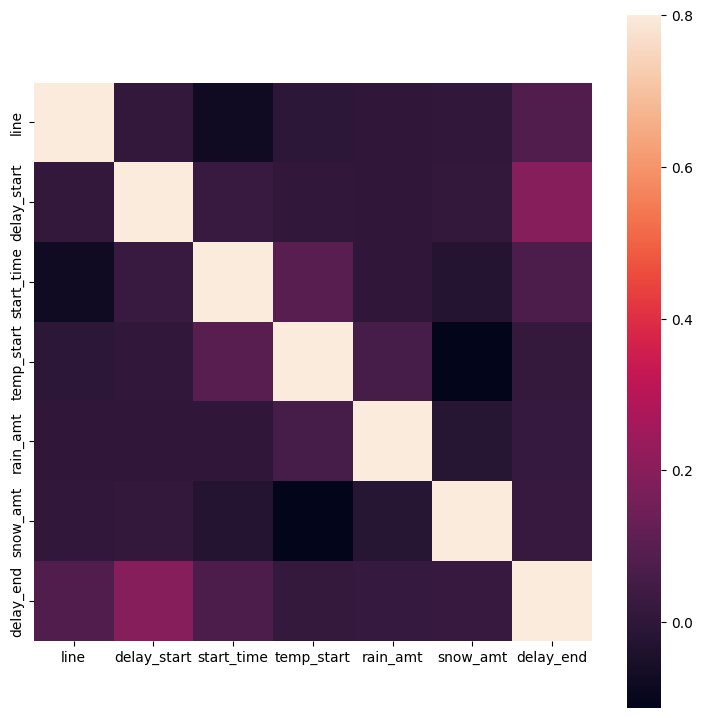

In [3]:
Corr_mat = df_test.corr()
fig = plt.figure(figsize = (9,9))

sb.heatmap(Corr_mat, vmax = .8, square = True)
plt.show()

In [4]:
predictors = ['delay_start', 'start_time', 'temp_start', 'rain_amt', 'snow_amt', 'line']
outcome = 'delay_end'

In [5]:
for i in range(len(predictors)):
    for j in range(len(predictors)):
        if i<j:
            corr, _ = pearsonr(df_test[predictors[i]], df_test[predictors[j]])
            print('The correlation between', predictors[i], 'and', predictors[j], 'is', corr)

The correlation between delay_start and start_time is 0.02443191113084113
The correlation between delay_start and temp_start is 0.005926468145248256
The correlation between delay_start and rain_amt is 0.00391874668369688
The correlation between delay_start and snow_amt is 0.008249960576945126
The correlation between delay_start and line is 0.011574383589575663
The correlation between start_time and temp_start is 0.10077189984427724
The correlation between start_time and rain_amt is 0.00425334001924677
The correlation between start_time and snow_amt is -0.024176273843384725
The correlation between start_time and line is -0.07727617810622817
The correlation between temp_start and rain_amt is 0.05680562338511451
The correlation between temp_start and snow_amt is -0.11309762999522527
The correlation between temp_start and line is -0.0042074495148836325
The correlation between rain_amt and snow_amt is -0.018916201405556533
The correlation between rain_amt and line is 0.00406770491632639
The

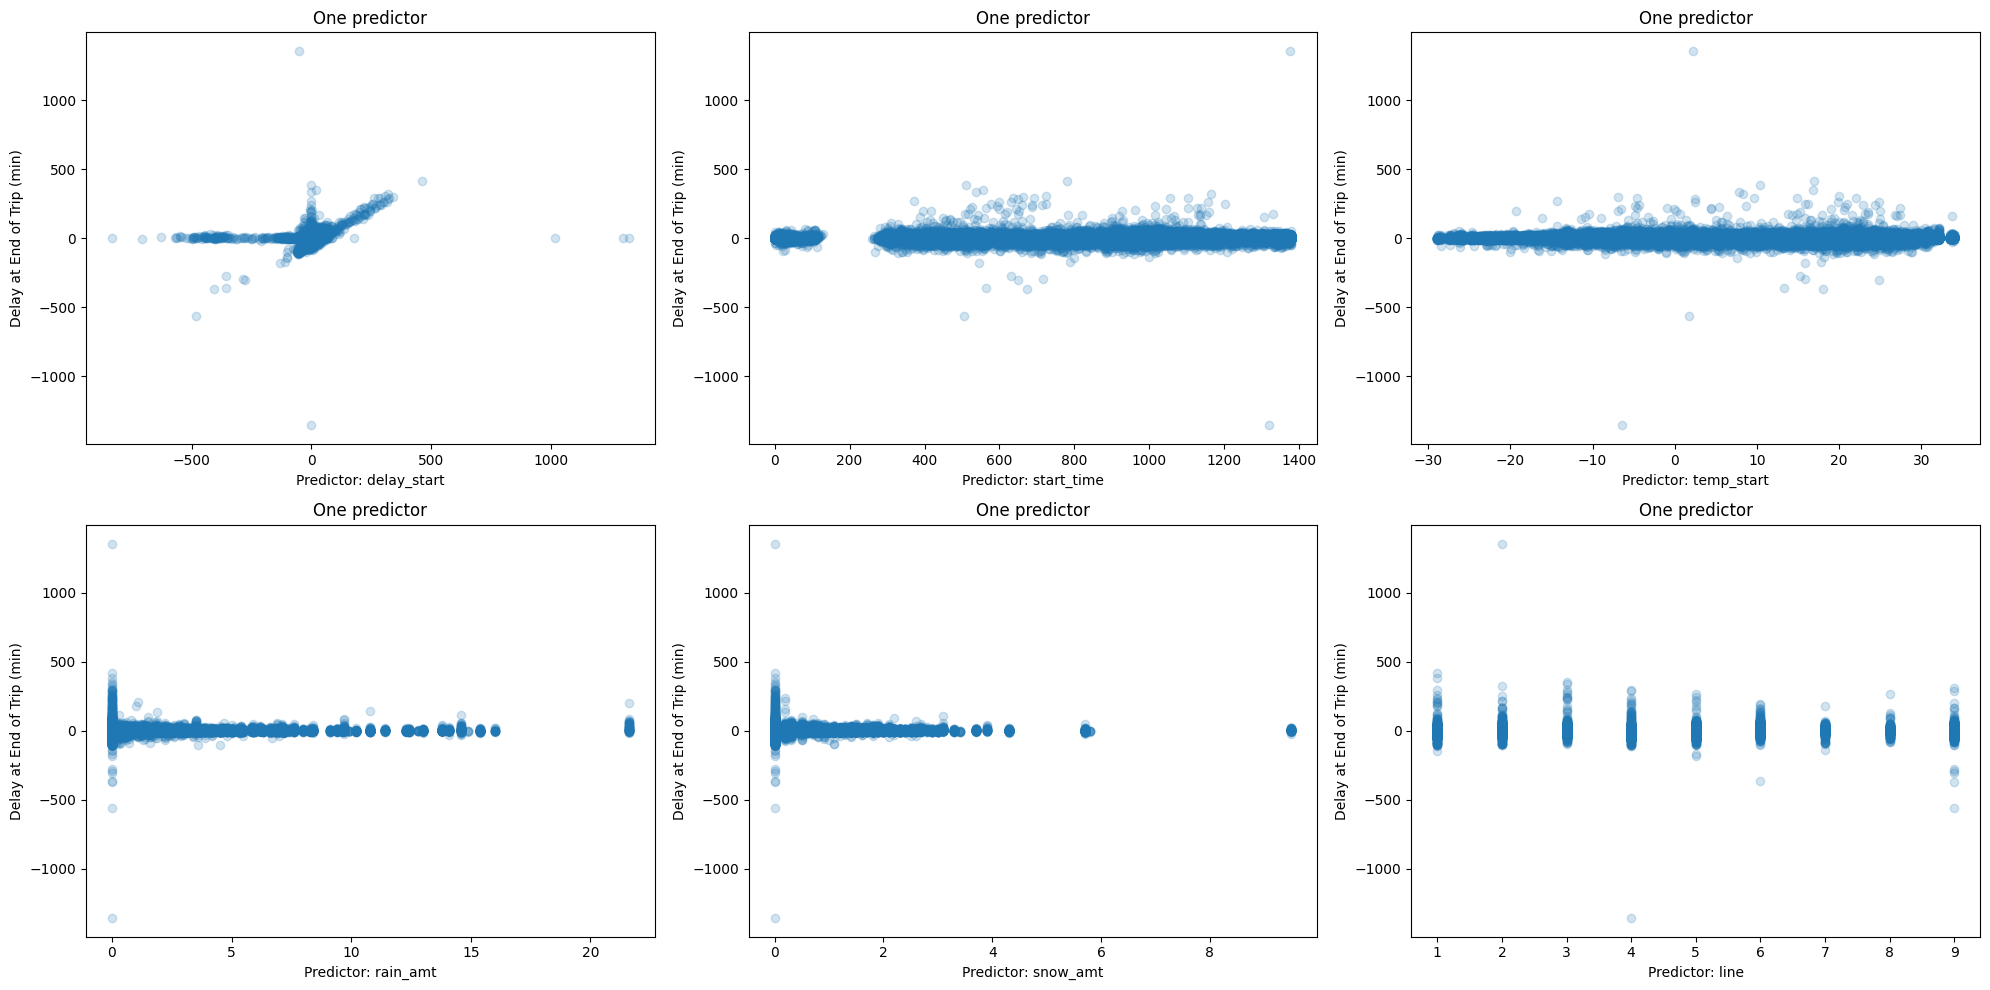

In [6]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

for i, axi in enumerate(ax.flat):
    axi.scatter(df_test[predictors[i]], df_test[outcome], color='tab:blue', alpha=0.2)
    axi.set_ylabel('Delay at End of Trip (min)')
    axi.set_xlabel(f'Predictor: {predictors[i]}')
    axi.set_title("One predictor");

plt.tight_layout()
plt.show()

In [7]:
model = sm.OLS(df_test[outcome], df_test[predictors].assign(const=1))
results = model.fit()

In [8]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              delay_end   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     5998.
Date:                Tue, 28 Nov 2023   Prob (F-statistic):               0.00
Time:                        12:38:02   Log-Likelihood:            -2.4334e+06
No. Observations:              697550   AIC:                         4.867e+06
Df Residuals:                  697543   BIC:                         4.867e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
delay_start     0.2073      0.001    163.832      0.000       0.205       0.210
start_time      0.0018      3e-05     60.341      0.000       0.002       0.002
temp_start      0.0048      0.001      5.971      0.000       0.003       0.006
rain_amt        0.2018      0.014     14.107      0.000       0.174       0.230
snow_amt        0.8121      0.043     19.077      0.000       0.729       0.896
line            0.2835      0.004     67.653      0.000       0.275       0.292
const          -0.2914      0.031     -9.280      0.000      -0.353      -0.230
==============================================================================
Omnibus:                   537217.729   Durbin-Watson:                   1.555
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     195004436719.336
Skew:                           1.488   Prob(JB):                         0.00
Kurtosis:                    2593.239   Cond. No.                     3.78e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.78e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [9]:
mse = results.mse_resid

In [10]:
mse**0.5

7.921241181097022

In [11]:
results.params

delay_start    0.207299
start_time     0.001813
temp_start     0.004778
rain_amt       0.201840
snow_amt       0.812094
line           0.283506
const         -0.291413
dtype: float64

In [12]:
para = results.params
delay = 2
time = 7*60 + 30
temp = 15
rain = 0.1
snow = 0
line = 1

X = [delay, time, temp, rain, snow,line,1]
prediction = np.dot(para, X)
print(f"The bus should be delayed by {prediction} minutes.")


The bus should be delayed by 1.3144960834516608 minutes.


We have a very unreliable model with R-squared 0.049\
The data is too noisy to find any linearity\
We will try to find clusters of data that might be helpful in finding a relationship between the variables

In [13]:
#find the delays over 90% of the mean delay
# first we find the mean delay
mean_delay = df_master['delay_end'].mean()
cutoff = mean_delay*0.9
print(cutoff)


2.168390366281987


In [14]:
df_m = df_master.copy()
df_m = df_m.drop(columns=['date'])

In [15]:
#create a new column for time of day in minutes (tod_end) and another one for the hour of the day (hour_end)
df_m['tod_end'] = pd.to_datetime(df_m['end_time'], format='%H:%M:%S')
df_m['tod_end'] = df_m['tod_end'].dt.hour * 60 + df_m['tod_end'].dt.minute
df_m['hour_end'] = pd.to_datetime(df_m['end_time'], format='%H:%M:%S')
df_m['hour_end'] = df_m['hour_end'].dt.hour

#convert the start_time column to minutes after midnight
df_m['start_time'] = pd.to_datetime(df_m['start_time'], format='%H:%M:%S')
df_m['start_time'] = df_m['start_time'].dt.hour * 60 + df_m['start_time'].dt.minute

df_m.head()

line  delay_start  start_time  end_time  temp_start  rain_amt  snow_amt  \
0  100.0            0          10  00:44:00        15.1       0.0       0.0   
1  100.0            0          42  01:14:00        15.1       0.0       0.0   
2  100.0           -1          73  01:44:00        13.7       0.0       0.0   
3  100.0            0         306  05:39:00        11.8       0.0       0.0   
4  100.0            2         341  06:13:00        11.8       0.0       0.0   

   delay_end  tod_end  hour_end  
0         -1       44         0  
1         -3       74         1  
2         -5      104         1  
3         -2      339         5  
4         -1      373         6

In [16]:
#take data as delay as a function of end time (sort by end time)
#scan the data for any delays over the cutoff
#if there is a delay over the cutoff, check the next datapoint to see if it is also over the cutoff
#if it is, add the delay to a new dataframe

#create a dictionary of dataframes for each line AND hour of the day
df_line_hour = {value: df_m.loc[df_m['hour_end'] == value] for value in df_m['hour_end'].unique()}
df_line_hour = {key: {value: df_line_hour[key].loc[df_line_hour[key]['line'] == value] for value in df_line_hour[key]['line'].unique()} for key in df_line_hour.keys()}
#each dataframe can be accessed by df_line_hour[hour][line], e.g. df_line_hour[7][1] is the dataframe for line 1 at 7am

# Create dictionary df_lhtop10 to store the dataframes with delays over 90% of the mean delay
df_lhtop10 = {key: {} for key in df_line_hour.keys()}

for key in df_line_hour.keys():
    for value in df_line_hour[key].keys():
        # Sort df_line_hour[hour][line] by the values of 'tod_end'
        df_line_hour[key][value] = df_line_hour[key][value].sort_values(by='tod_end')
        # Create a boolean mask for rows where 'delay_end' is greater than or equal to the cutoff
        mask = df_line_hour[key][value]['delay_end'] >= cutoff
        # Shift the mask by one to compare with the next row
        mask_shifted = mask.shift(-1)
        # Combine the masks and select the rows from df_line_hour[hour][line]
        df_lhtop10[key][value] = df_line_hour[key][value][mask & mask_shifted].copy()

#each dataframe in df_lhtop10 can be accessed by df_lhtop10[hour][line], e.g. df_lhtop10[7][1] is the dataframe for line 1 at 7am



# Remove dataframes with less than 10 rows
for key in df_lhtop10.keys():
    for value in list(df_lhtop10[key].keys()):  # Create a list of keys since we're modifying the dictionary
        if len(df_lhtop10[key][value]) < 10:
            df_lhtop10[key].pop(value, None)

# print a list of all the keys (meaning dataframes with delays over 90% of the mean delay)
for key in df_lhtop10.keys():
    for value in df_lhtop10[key].keys():
        print(key, value)

#print the amount of dataframes in df_lhtop10
total_dfs = sum(len(df_lhtop10[hour]) for hour in df_lhtop10.keys())
print(total_dfs)

0 100.0
0 121.0
0 67.0
0 80.0
0 139.0
0 439.0
1 100.0
1 121.0
1 67.0
1 80.0
1 139.0
1 439.0
5 100.0
5 121.0
5 139.0
5 67.0
5 80.0
5 439.0
6 100.0
6 121.0
6 139.0
6 439.0
6 460.0
6 467.0
6 67.0
6 80.0
7 100.0
7 121.0
7 139.0
7 439.0
7 460.0
7 467.0
7 480.0
7 67.0
7 80.0
8 100.0
8 121.0
8 139.0
8 439.0
8 460.0
8 467.0
8 480.0
8 67.0
8 80.0
9 100.0
9 121.0
9 139.0
9 439.0
9 460.0
9 467.0
9 480.0
9 67.0
9 80.0
10 100.0
10 121.0
10 139.0
10 460.0
10 467.0
10 480.0
10 67.0
10 80.0
10 439.0
11 100.0
11 121.0
11 139.0
11 467.0
11 67.0
11 80.0
11 439.0
12 100.0
12 121.0
12 139.0
12 467.0
12 67.0
12 80.0
12 439.0
13 100.0
13 121.0
13 139.0
13 467.0
13 67.0
13 80.0
13 439.0
14 100.0
14 121.0
14 139.0
14 467.0
14 67.0
14 80.0
14 439.0
15 100.0
15 121.0
15 139.0
15 439.0
15 467.0
15 67.0
15 80.0
15 460.0
16 100.0
16 121.0
16 139.0
16 439.0
16 460.0
16 467.0
16 480.0
16 67.0
16 80.0
17 100.0
17 121.0
17 139.0
17 439.0
17 460.0
17 467.0
17 480.0
17 67.0
17 80.0
18 100.0
18 121.0
18 139.0
18 439.0
18 

In [17]:
total_dfs = sum(len(df_lhtop10[hour]) for hour in df_lhtop10.keys())
print(total_dfs)

165


In [18]:
total_dfs = sum(len(df_lhtop10[hour]) for hour in df_lhtop10.keys())
print(total_dfs)

165


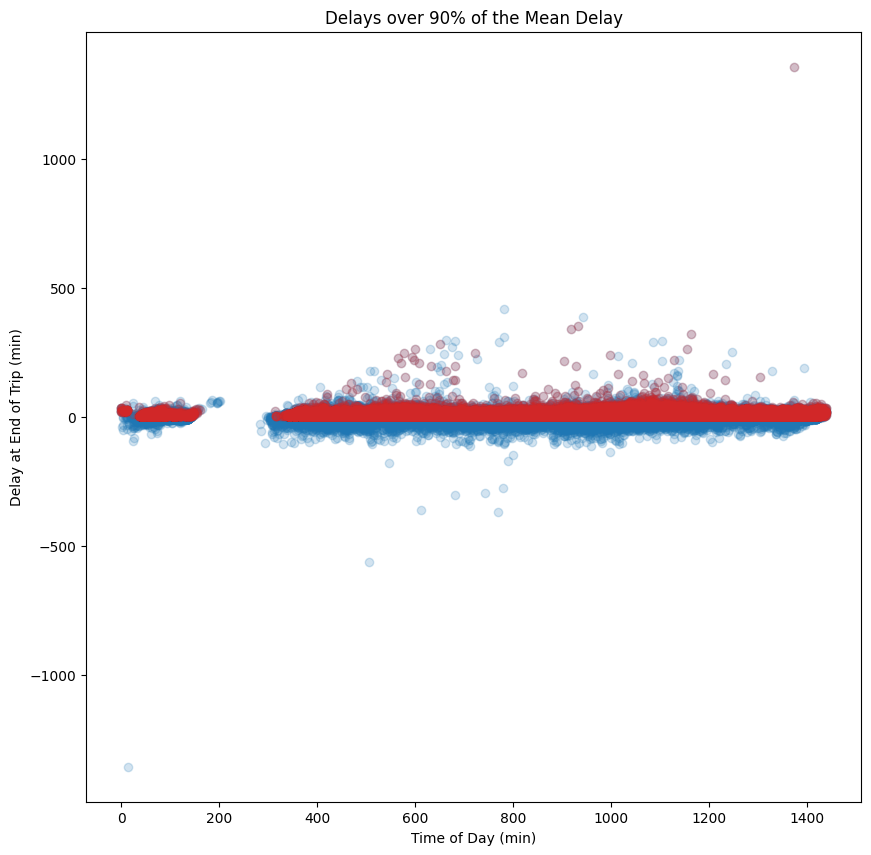

In [19]:
# Create a new dataframe with all the dataframes in df_lhtop10
df_top10 = pd.concat([df_lhtop10[key][value] for key in df_lhtop10.keys() for value in df_lhtop10[key].keys()])
df_top10 = df_top10.sort_values(by='tod_end')
df_top10.head()

#visualize the data by plotting df_m and df_top10  with delay_end on the y axis and tod_end on the x axis
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(df_m['tod_end'], df_m['delay_end'], color='tab:blue', alpha=0.2)
ax.scatter(df_top10['tod_end'], df_top10['delay_end'], color='tab:red', alpha=0.2)
ax.set_ylabel('Delay at End of Trip (min)')
ax.set_xlabel('Time of Day (min)')
ax.set_title('Delays over 90% of the Mean Delay')
plt.show()


In [20]:
#create a model with each dataframe in df_lhtop10 and return the r-squared value

# Create a dictionary to store the r-squared values
rsquared = {key: {} for key in df_lhtop10.keys()}

for key in df_lhtop10.keys():
    for value in df_lhtop10[key].keys():
        # Create a model for each dataframe in df_lhtop10
        model = sm.OLS(df_lhtop10[key][value]['delay_end'], df_lhtop10[key][value][predictors])
        results = model.fit()
        # Store the r-squared value in rsquared
        rsquared[key][value] = results.rsquared

# Print the r-squared values
for key in rsquared.keys():
    for value in rsquared[key].keys():
        print(key, value, rsquared[key][value])



0 100.0 0.3470785167983431
0 121.0 0.9361465852505668
0 67.0 0.9287340051636533
0 80.0 0.4123430912902939
0 139.0 0.47974263186422805
0 439.0 0.3975283280583909
1 100.0 0.5866019957151203
1 121.0 0.30847446892660946
1 67.0 0.09652587984609806
1 80.0 0.4244502461840389
1 139.0 0.08555330725338028
1 439.0 0.19840345270401227
5 100.0 0.7729909023874847
5 121.0 0.10124582647756519
5 139.0 0.14080162307574073
5 67.0 0.35627757317464726
5 80.0 0.0027789751403497487
5 439.0 0.029225597977548756
6 100.0 0.1552932550604229
6 121.0 0.14050081465736008
6 139.0 0.19582057982156698
6 439.0 0.31842014137541175
6 460.0 0.21346800136694566
6 467.0 0.07301620787977614
6 67.0 0.42346017403183756
6 80.0 0.12191174233271462
7 100.0 0.25657320572118936
7 121.0 0.3948158143079379
7 139.0 0.19002659079485473
7 439.0 0.055615412418048016
7 460.0 0.09372863376473284
7 467.0 0.03379263329677007
7 480.0 0.18286096315359823
7 67.0 0.3238974956367241
7 80.0 0.2510644184836369
8 100.0 0.07048794277577286
8 121.0 0.

In [21]:
# remove end_time, tod_end and hour_end from all dataframes in df_lhtop10

for key in df_lhtop10.keys():
    for value in df_lhtop10[key].keys():
        df_lhtop10[key][value] = df_lhtop10[key][value].drop(columns=['end_time', 'tod_end', 'hour_end'])


In [22]:
# merge all dataframes in df_lhtop10 into one dataframe
df_final = pd.concat([df_lhtop10[key][value] for key in df_lhtop10.keys() for value in df_lhtop10[key].keys()])
df_final = df_final.sort_values(by='start_time')
df_final.head()


line  delay_start  start_time  temp_start  rain_amt  snow_amt  \
295583   80.0            0           0        15.3       0.0       0.0   
492136   80.0            0           0        -6.2       0.0       0.0   
112898  139.0            2           0       -21.7       0.0       0.0   
225462  139.0            3           0        13.6       0.0       0.0   
37734    80.0            0           0         8.4       0.0       0.0   

        delay_end  
295583          7  
492136          5  
112898         10  
225462         11  
37734           5

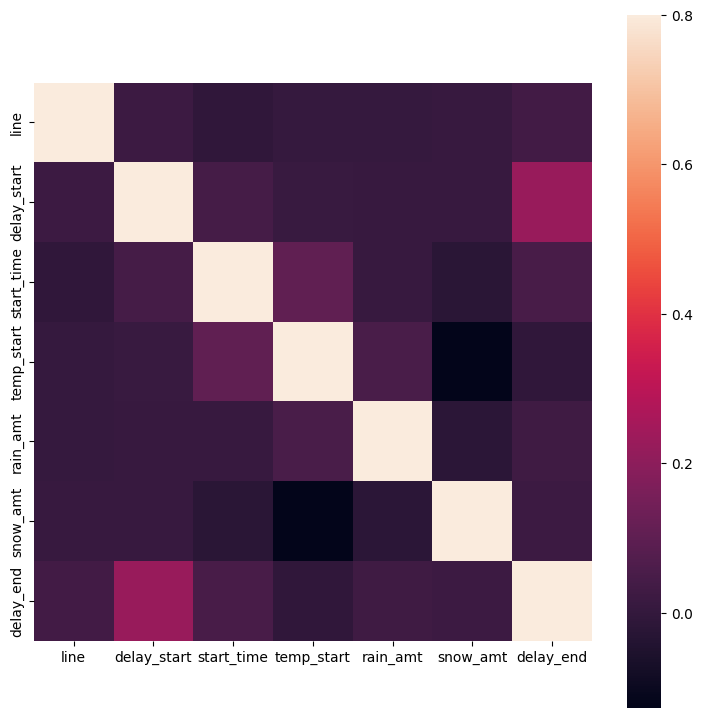

In [23]:
Corr_mat = df_final.corr()
fig = plt.figure(figsize = (9,9))

sb.heatmap(Corr_mat, vmax = .8, square = True)
plt.show()

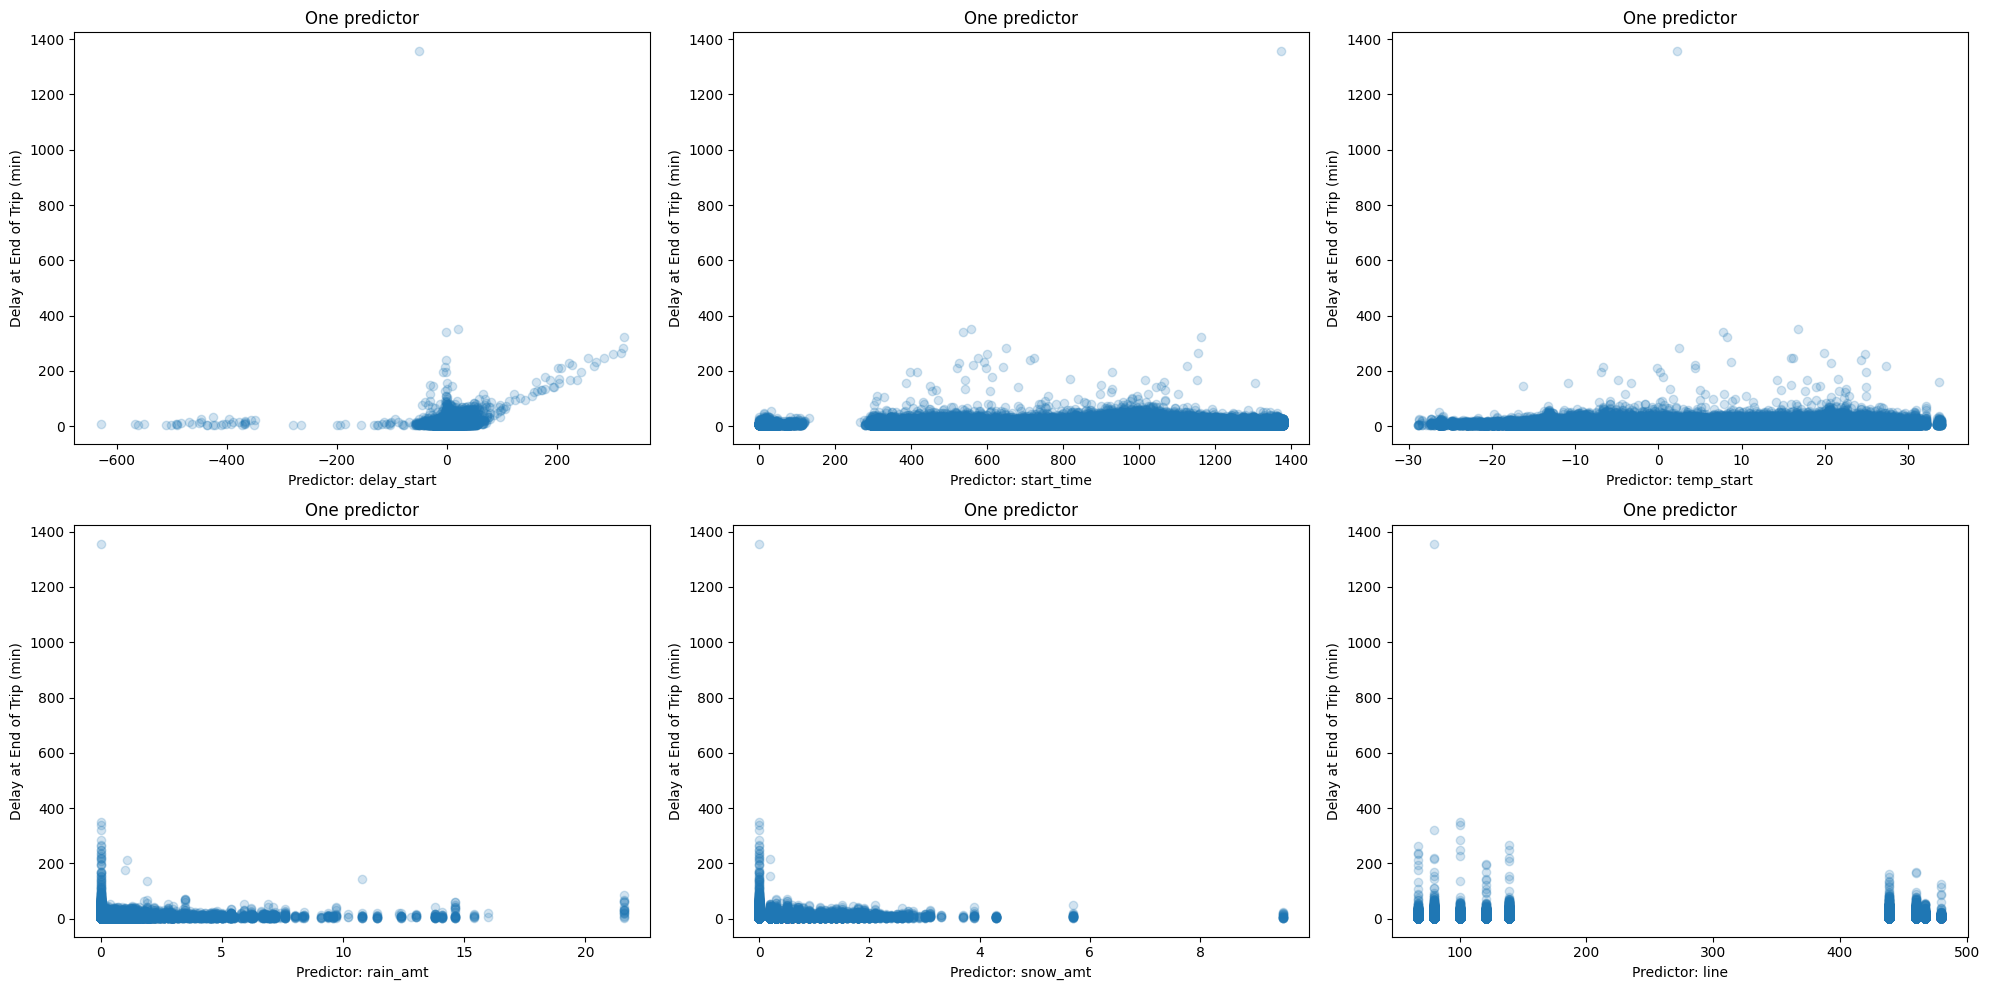

In [24]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

for i, axi in enumerate(ax.flat):
    axi.scatter(df_final[predictors[i]], df_final[outcome], color='tab:blue', alpha=0.2)
    axi.set_ylabel('Delay at End of Trip (min)')
    axi.set_xlabel(f'Predictor: {predictors[i]}')
    axi.set_title("One predictor");

plt.tight_layout()
plt.show()

In [25]:
model = sm.OLS(df_final[outcome], df_final[predictors].assign(const=1))
results = model.fit()

In [26]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              delay_end   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     1600.
Date:                Tue, 28 Nov 2023   Prob (F-statistic):               0.00
Time:                        12:38:19   Log-Likelihood:            -5.6936e+05
No. Observations:              167749   AIC:                         1.139e+06
Df Residuals:                  167742   BIC:                         1.139e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
delay_start     0.1914      0.002     93.278      0.000       0.187       0.195
start_time      0.0011    6.2e-05     18.052      0.000       0.001       0.001
temp_start     -0.0098      0.001     -6.553      0.000      -0.013      -0.007
rain_amt        0.2959      0.026     11.230      0.000       0.244       0.347
snow_amt        0.5025      0.075      6.741      0.000       0.356       0.649
line            0.0014      0.000     13.082      0.000       0.001       0.002
const           7.3303      0.059    125.088      0.000       7.215       7.445
==============================================================================
Omnibus:                   512699.719   Durbin-Watson:                   1.867
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     407042958059.800
Skew:                          45.181   Prob(JB):                         0.00
Kurtosis:                    7633.717   Cond. No.                     3.75e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.75e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [27]:
model4 = sm.OLS(df_final['delay_end'], df_final['delay_start'])
results = model4.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              delay_end   R-squared (uncentered):                   0.051
Model:                            OLS   Adj. R-squared (uncentered):              0.051
Method:                 Least Squares   F-statistic:                              9008.
Date:                Tue, 28 Nov 2023   Prob (F-statistic):                        0.00
Time:                        12:38:19   Log-Likelihood:                     -6.4198e+05
No. Observations:              167749   AIC:                                  1.284e+06
Df Residuals:                  167748   BIC:                                  1.284e+06
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
delay_start     0.2983      0.003     94.911      0.000       0.292       0.304
==============================================================================
Omnibus:                   510772.554   Durbin-Watson:                   0.801
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     389810494545.510
Skew:                          44.708   Prob(JB):                         0.00
Kurtosis:                    7470.432   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
model5 = sm.OLS(df_master['delay_end'], df_master['delay_start'])
results = model5.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              delay_end   R-squared (uncentered):                   0.041
Model:                            OLS   Adj. R-squared (uncentered):              0.041
Method:                 Least Squares   F-statistic:                          2.987e+04
Date:                Tue, 28 Nov 2023   Prob (F-statistic):                        0.00
Time:                        12:38:19   Log-Likelihood:                     -2.4657e+06
No. Observations:              697550   AIC:                                  4.931e+06
Df Residuals:                  697549   BIC:                                  4.931e+06
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
delay_start     0.2285      0.001    172.819      0.000       0.226       0.231
==============================================================================
Omnibus:                   543650.395   Durbin-Watson:                   1.419
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     185910812640.508
Skew:                           1.545   Prob(JB):                         0.00
Kurtosis:                    2532.123   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The model is still very unreliable, there is not enough data to correlate weather with delays\
We will attempt to add traffic data

In [80]:
df_test2 = pd.read_csv('../Data/master_data_traffic.csv')

In [81]:
df_test2 = df_test2.drop(columns=['date','end_time'])

# Extract only the time part from the datetime string
df_test2['start_time'] = df_test2['start_time'].str.split(' ').str[1]

# Convert the start_time column to minutes after midnight
df_test2['start_time'] = pd.to_datetime(df_test2['start_time'], format='%H:%M:%S')
df_test2['start_time'] = df_test2['start_time'].dt.hour * 60 + df_test2['start_time'].dt.minute

df_test2.head()


line  delay_start  start_time  temp_start  rain_amt  snow_amt  delay_end  \
0   467            0         405         7.1       0.0       0.0          6   
1   467            1         437         6.9       0.0       0.0          5   
2   467            1         468         6.9       0.0       0.0          6   
3   467           -1         496         6.5       0.0       0.0          6   
4   467            0         527         6.5       0.0       0.0          6   

   total_traffic  T_NBLT   T_NBT  T_NBRT  T_SBLT   T_SBT  T_SBRT  T_EBLT  \
0         3674.0     0.0  1236.0    23.0     4.0  1270.0   155.0   165.0   
1         3116.0     0.0  1031.0    56.0     0.0   927.0   103.0   130.0   
2         3984.0     0.0  1330.0    44.0     0.0  1167.0   170.0   191.0   
3         2655.0     0.0   853.0    35.0     0.0   884.0   113.0   116.0   
4         2273.0     0.0   762.0    32.0     0.0   774.0    81.0    96.0   

   T_EBT  T_EBRT  T_WBLT  T_WBT  T_WBRT  
0  157.0    68.0     2.0  478.0   116.0  
1  238.0    45.0     0.0  473.0   113.0  
2  312.0    89.0     3.0  567.0   111.0  
3  171.0    86.0     1.0  321.0    75.0  
4  164.0    47.0     1.0  253.0    63.0

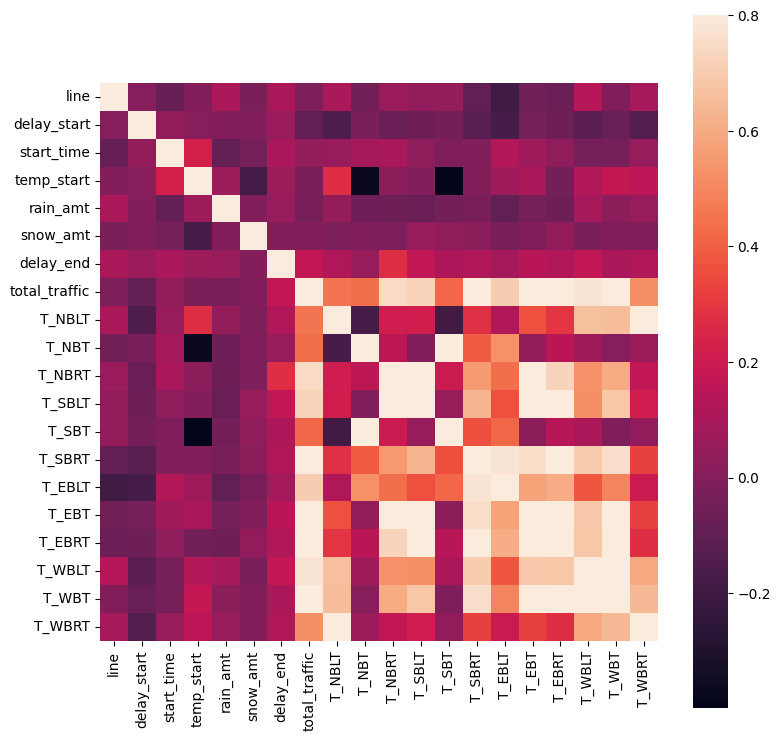

In [82]:
Corr_mat = df_test2.corr()
fig = plt.figure(figsize = (9,9))

sb.heatmap(Corr_mat, vmax = .8, square = True)
plt.show()

In [83]:
#set predictors_t as all columns of df_test2 except delay_end
predictors_t = df_test2.columns.tolist()
predictors_t.remove('delay_end')
outcome_t = 'delay_end'

In [84]:
#convert all columns to float
for col in predictors_t:
    df_test2[col] = df_test2[col].astype(float)

for i in range(len(predictors_t)):
    for j in range(len(predictors_t)):
        if i < j:
            corr, _ = pearsonr(df_test2[predictors_t[i]], df_test2[predictors_t[j]])
            print('The correlation between', predictors_t[i], 'and', predictors_t[j], 'is', str(corr))

The correlation between line and delay_start is 0.0042326257648843445
The correlation between line and start_time is -0.0813147427825599
The correlation between line and temp_start is 0.0011059130260820324
The correlation between line and rain_amt is 0.10817207314619826
The correlation between line and snow_amt is -0.02099615729686905
The correlation between line and total_traffic is -0.01674587760425039
The correlation between line and T_NBLT is 0.10464780116958133
The correlation between line and T_NBT is -0.05714589354046702
The correlation between line and T_NBRT is 0.0616162236986575
The correlation between line and T_SBLT is 0.040488953254499985
The correlation between line and T_SBT is 0.04429601561023413
The correlation between line and T_SBRT is -0.09393275088786159
The correlation between line and T_EBLT is -0.19628837791013434
The correlation between line and T_EBT is -0.05214984500973917
The correlation between line and T_EBRT is -0.07167294918584301
The correlation between

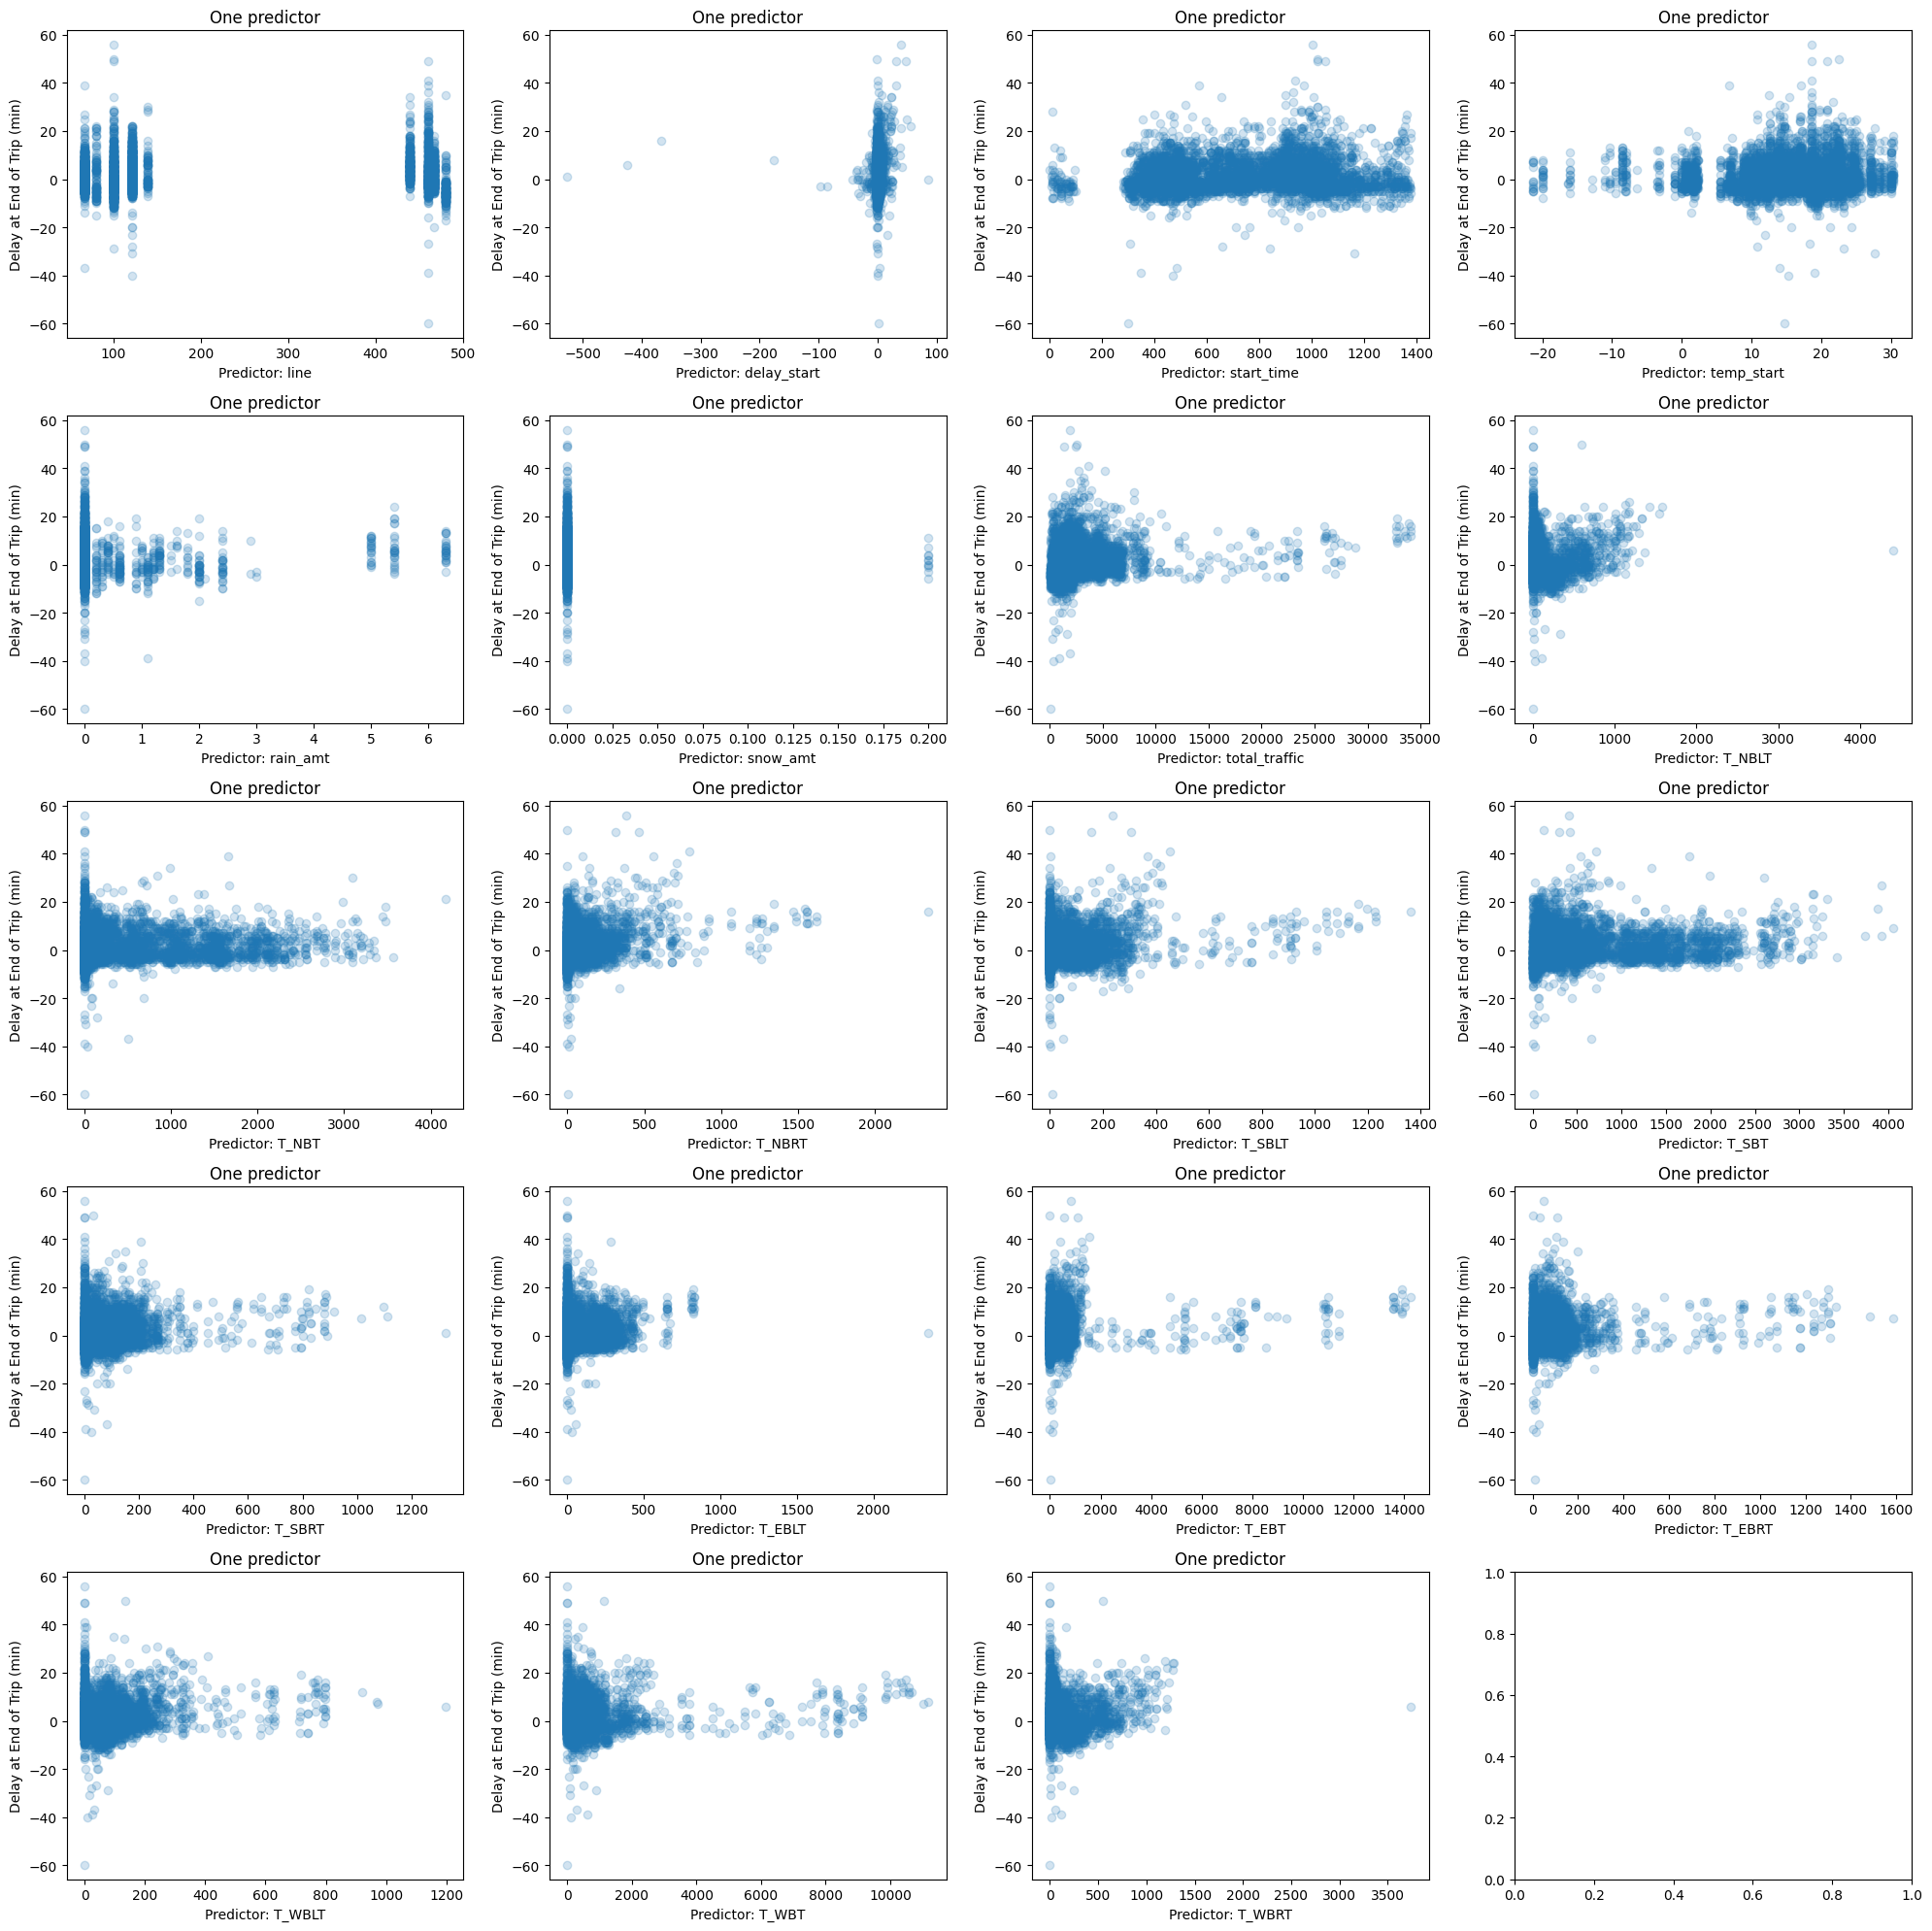

In [85]:
fig, ax = plt.subplots(5, 4, figsize=(20, 20))

if len(predictors_t) <= len(ax.flat):
    for i, axi in enumerate(ax.flat):
        if i < len(predictors_t):
            axi.scatter(df_test2[predictors_t[i]], df_test2[outcome_t], color='tab:blue', alpha=0.2)
            axi.set_ylabel('Delay at End of Trip (min)')
            axi.set_xlabel(f'Predictor: {predictors_t[i]}')
            axi.set_title("One predictor")
else:
    print("Number of predictors exceeds the number of subplots")

plt.tight_layout()
plt.show()

In [86]:
#lets make a model with all lines

predictors_t2 = ['delay_start', 'start_time', 'temp_start', 'rain_amt', 'snow_amt', 'total_traffic']
outcome_t2 = 'delay_end'

model = sm.OLS(df_test2[outcome_t2], df_test2[predictors_t2].assign(const=1))
results = model.fit()

results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              delay_end   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     44.87
Date:                Wed, 29 Nov 2023   Prob (F-statistic):           8.69e-54
Time:                        13:10:15   Log-Likelihood:                -17009.
No. Observations:                5134   AIC:                         3.403e+04
Df Residuals:                    5127   BIC:                         3.408e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
delay_start       0.0417      0.008      5.312      0.000       0.026       0.057
start_time        0.0019      0.000      5.827      0.000       0.001       0.003
temp_start        0.0433      0.012      3.549      0.000       0.019       0.067
rain_amt          0.6417      0.129      4.960      0.000       0.388       0.895
snow_amt         11.3640     10.207      1.113      0.266      -8.647      31.375
total_traffic     0.0004   2.75e-05     12.874      0.000       0.000       0.000
const            -1.6028      0.294     -5.450      0.000      -2.179      -1.026
==============================================================================
Omnibus:                     1201.053   Durbin-Watson:                   1.368
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8628.430
Skew:                           0.927   Prob(JB):                         0.00
Kurtosis:                       9.075   Cond. No.                     4.74e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.74e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [87]:
#snow_amt is not significant (p>0.05), lets remove it

predictors_t3 = ['delay_start', 'start_time', 'temp_start', 'rain_amt', 'total_traffic']
outcome_t3 = 'delay_end'

model = sm.OLS(df_test2[outcome_t3], df_test2[predictors_t3].assign(const=1))
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              delay_end   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     53.60
Date:                Wed, 29 Nov 2023   Prob (F-statistic):           2.07e-54
Time:                        13:10:15   Log-Likelihood:                -17010.
No. Observations:                5134   AIC:                         3.403e+04
Df Residuals:                    5128   BIC:                         3.407e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
delay_start       0.0416      0.008      5.310      0.000       0.026       0.057
start_time        0.0019      0.000      5.831      0.000       0.001       0.003
temp_start        0.0409      0.012      3.406      0.001       0.017       0.064
rain_amt          0.6421      0.129      4.963      0.000       0.389       0.896
total_traffic     0.0004   2.75e-05     12.868      0.000       0.000       0.000
const            -1.5621      0.292     -5.353      0.000      -2.134      -0.990
==============================================================================
Omnibus:                     1200.710   Durbin-Watson:                   1.368
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8621.654
Skew:                           0.927   Prob(JB):                         0.00
Kurtosis:                       9.072   Cond. No.                     1.36e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.36e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [88]:
#make a dictionary of dataframes for each line
df_line_t = {value: df_test2.loc[df_test2['line'] == value] for value in df_test2['line'].unique()}
#each dataframe can be accessed by df_line_t[line], e.g. df_line_t[1] is the dataframe for line 1



In [89]:
#print keys of df_line_t
for key in df_line_t.keys():
    print(key)

467.0
67.0
480.0
121.0
80.0
100.0
460.0
139.0
439.0


In [90]:
#make a model for each line and store the r-squared values in a dictionary

# Create a dictionary to store the r-squared values
rsquared_t = {key: {} for key in df_line_t.keys()}

predictors_lines = ['delay_start', 'start_time', 'temp_start', 'rain_amt', 'total_traffic']
outcome_lines = 'delay_end'

for key in df_line_t.keys():
    # Create a model for each dataframe in df_line_t
    model = sm.OLS(df_line_t[key][outcome_lines], df_line_t[key][predictors_lines].assign(const=1))
    results = model.fit()
    # Store the r-squared value in rsquared
    rsquared_t[key] = results.rsquared

# Print the r-squared values rounded to 3 decimal places
for key in rsquared_t.keys():
    print(key, round(rsquared_t[key], 3))

467.0 0.052
67.0 0.033
480.0 0.212
121.0 0.084
80.0 0.411
100.0 0.339
460.0 0.325
139.0 0.118
439.0 0.278


In [91]:
#delay_end plotted against total_traffic is exponential, so we will take the exp of total_traffic

# Initialize a MinMaxScaler
scaler = MinMaxScaler()

for key in df_line_t.keys():
    # Fit the scaler to the total_traffic column and transform it
    df_line_t[key].loc[:, 'total_traffic_exp'] = scaler.fit_transform(df_line_t[key][['total_traffic']])
    
    # Apply the exponential function to the scaled total_traffic column
    df_line_t[key].loc[:, 'total_traffic_exp'] = np.exp(df_line_t[key]['total_traffic_exp'])

#make a model for each line and store the r-squared values in a dictionary

# Create a dictionary to store the r-squared values
rsquared_t = {key: {} for key in df_line_t.keys()}

predictors_lines_exp = ['delay_start', 'start_time', 'temp_start', 'rain_amt', 'total_traffic_exp']
outcome_lines_exp = 'delay_end'

for key in df_line_t.keys():
    # Create a model for each dataframe in df_line_t
    model = sm.OLS(df_line_t[key][outcome_lines_exp], df_line_t[key][predictors_lines_exp].assign(const=1))
    results = model.fit()
    # Store the r-squared value in rsquared
    rsquared_t[key] = results.rsquared

# Print the r-squared values rounded to 3 decimal places
for key in rsquared_t.keys():
    print(key, round(rsquared_t[key], 3))


467.0 0.056
67.0 0.035
480.0 0.24
121.0 0.084
80.0 0.434
100.0 0.339
460.0 0.302
139.0 0.134
439.0 0.284


C:\Users\fer_g\AppData\Local\Temp\ipykernel_21476\2242310265.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_line_t[key].loc[:, 'total_traffic_exp'] = scaler.fit_transform(df_line_t[key][['total_traffic']])
C:\Users\fer_g\AppData\Local\Temp\ipykernel_21476\2242310265.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_line_t[key].loc[:, 'total_traffic_exp'] = scaler.fit_transform(df_line_t[key][['total_traffic']])
C:\Users\fer_g\AppData\Local\Temp\ipykernel_21476\2242310265.py:8: SettingWithCopyWa

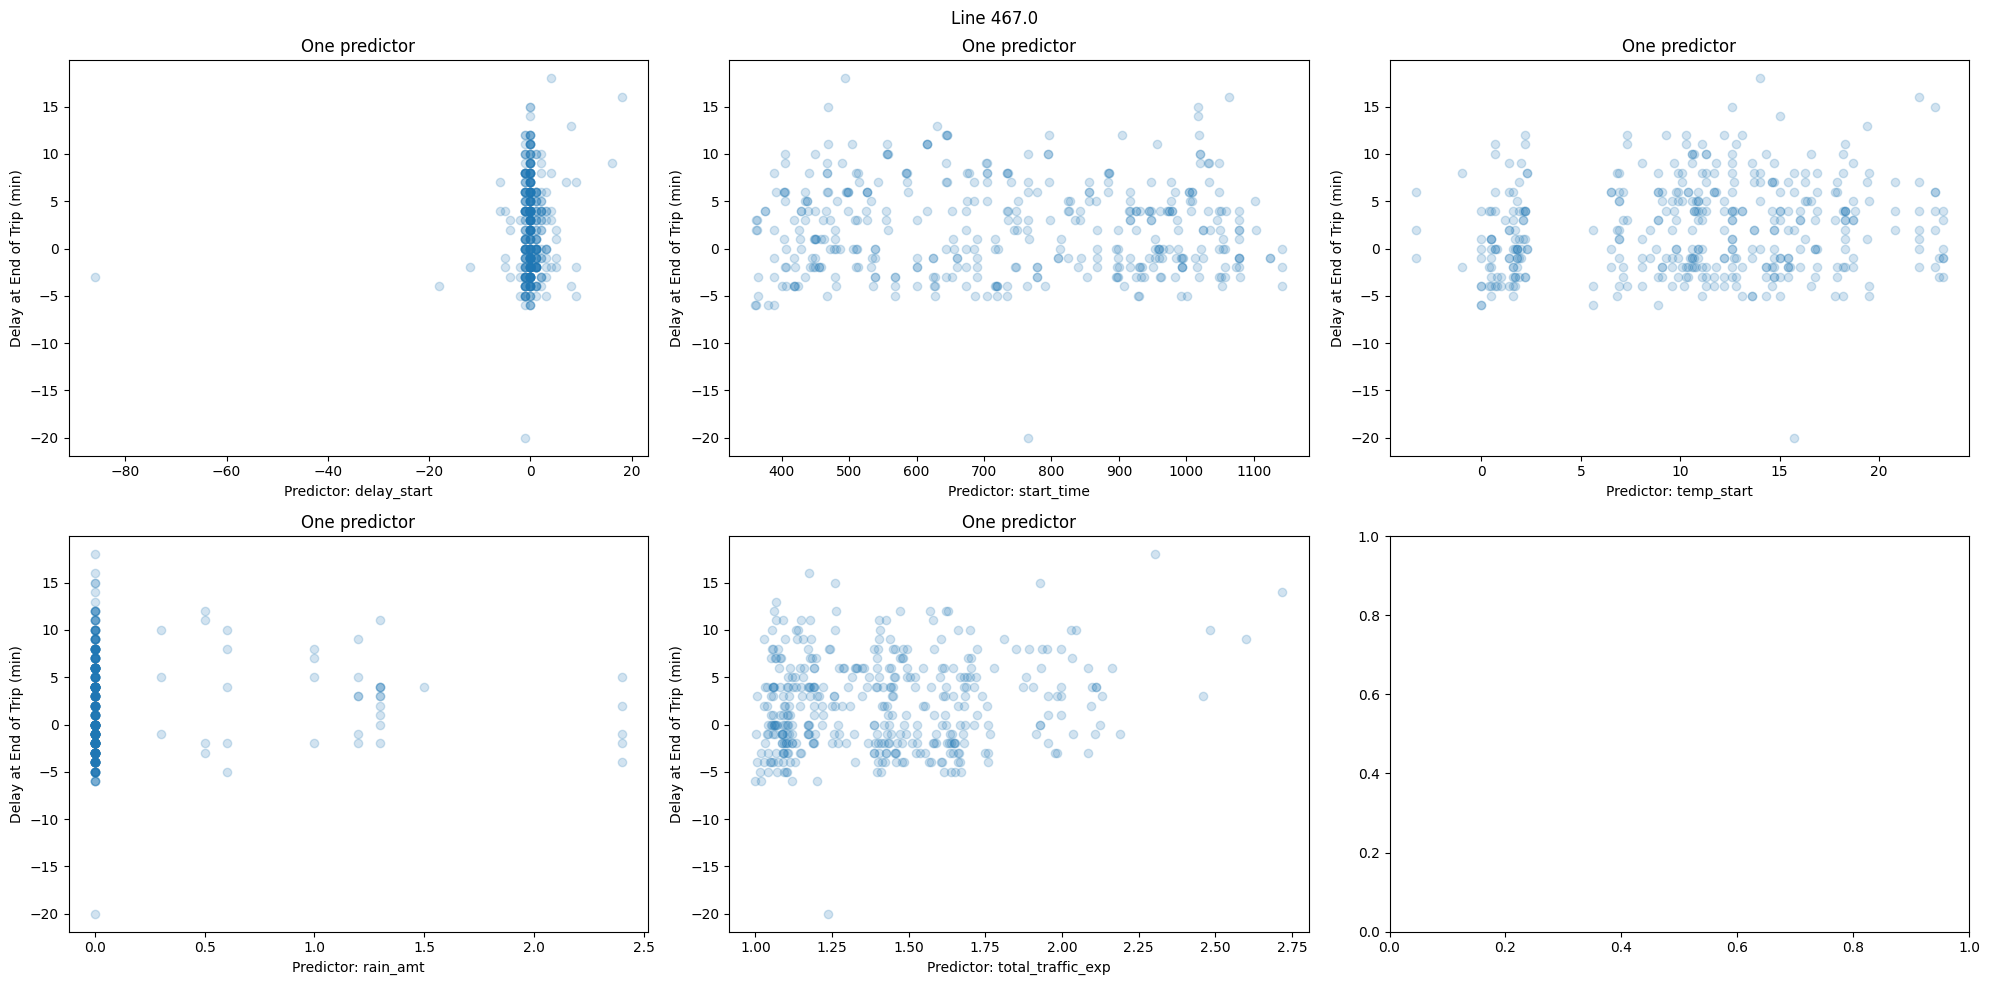

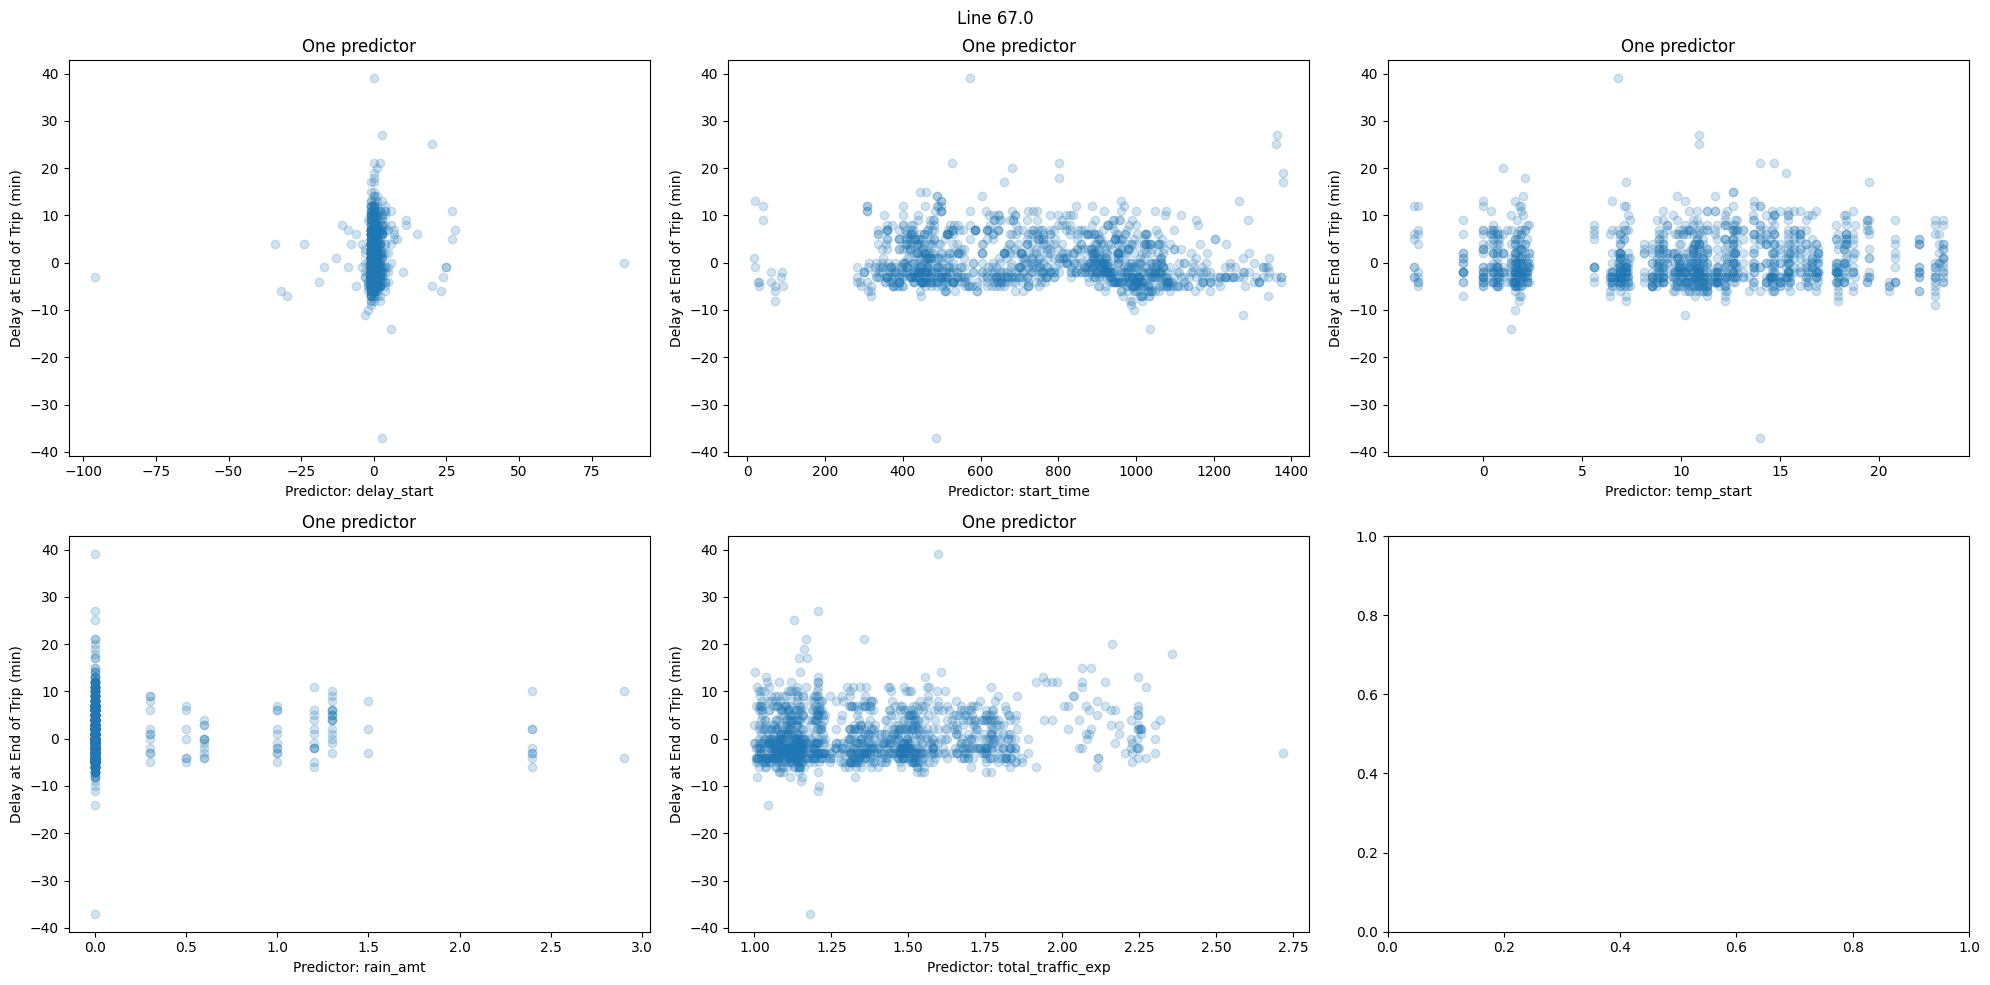

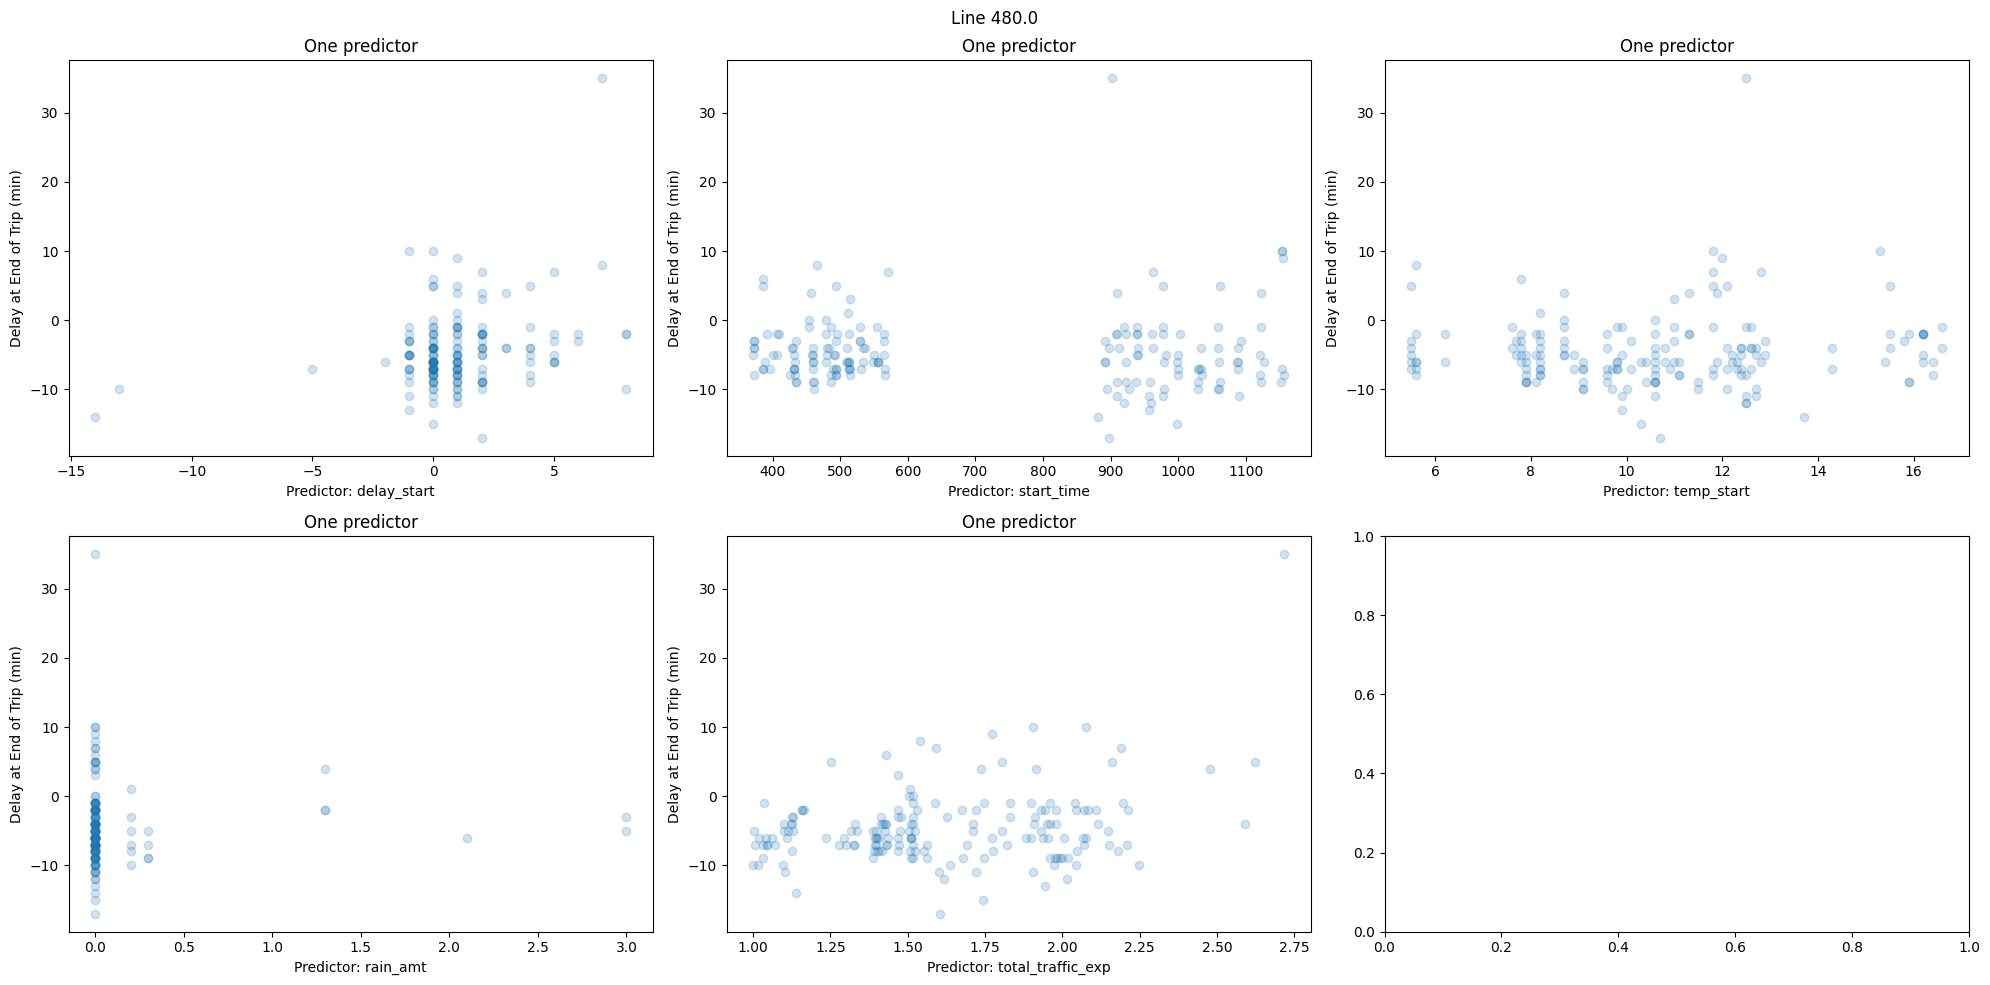

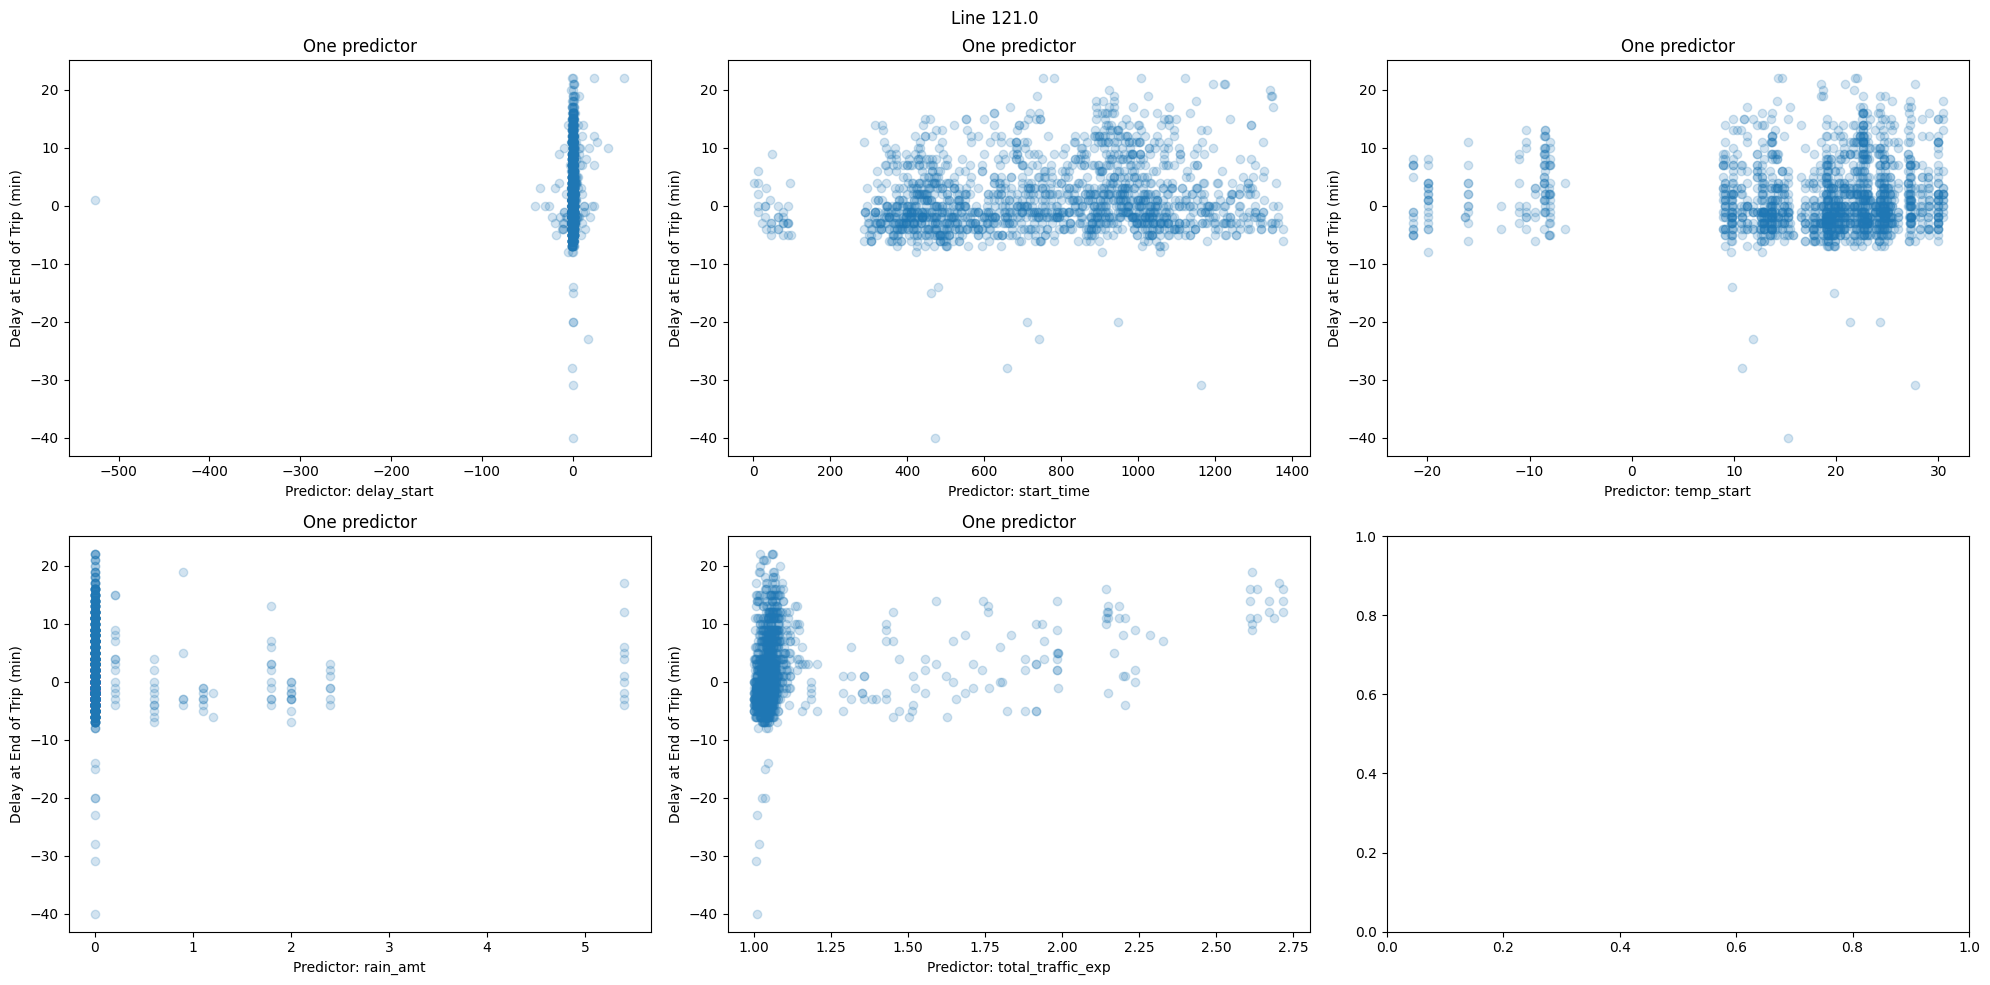

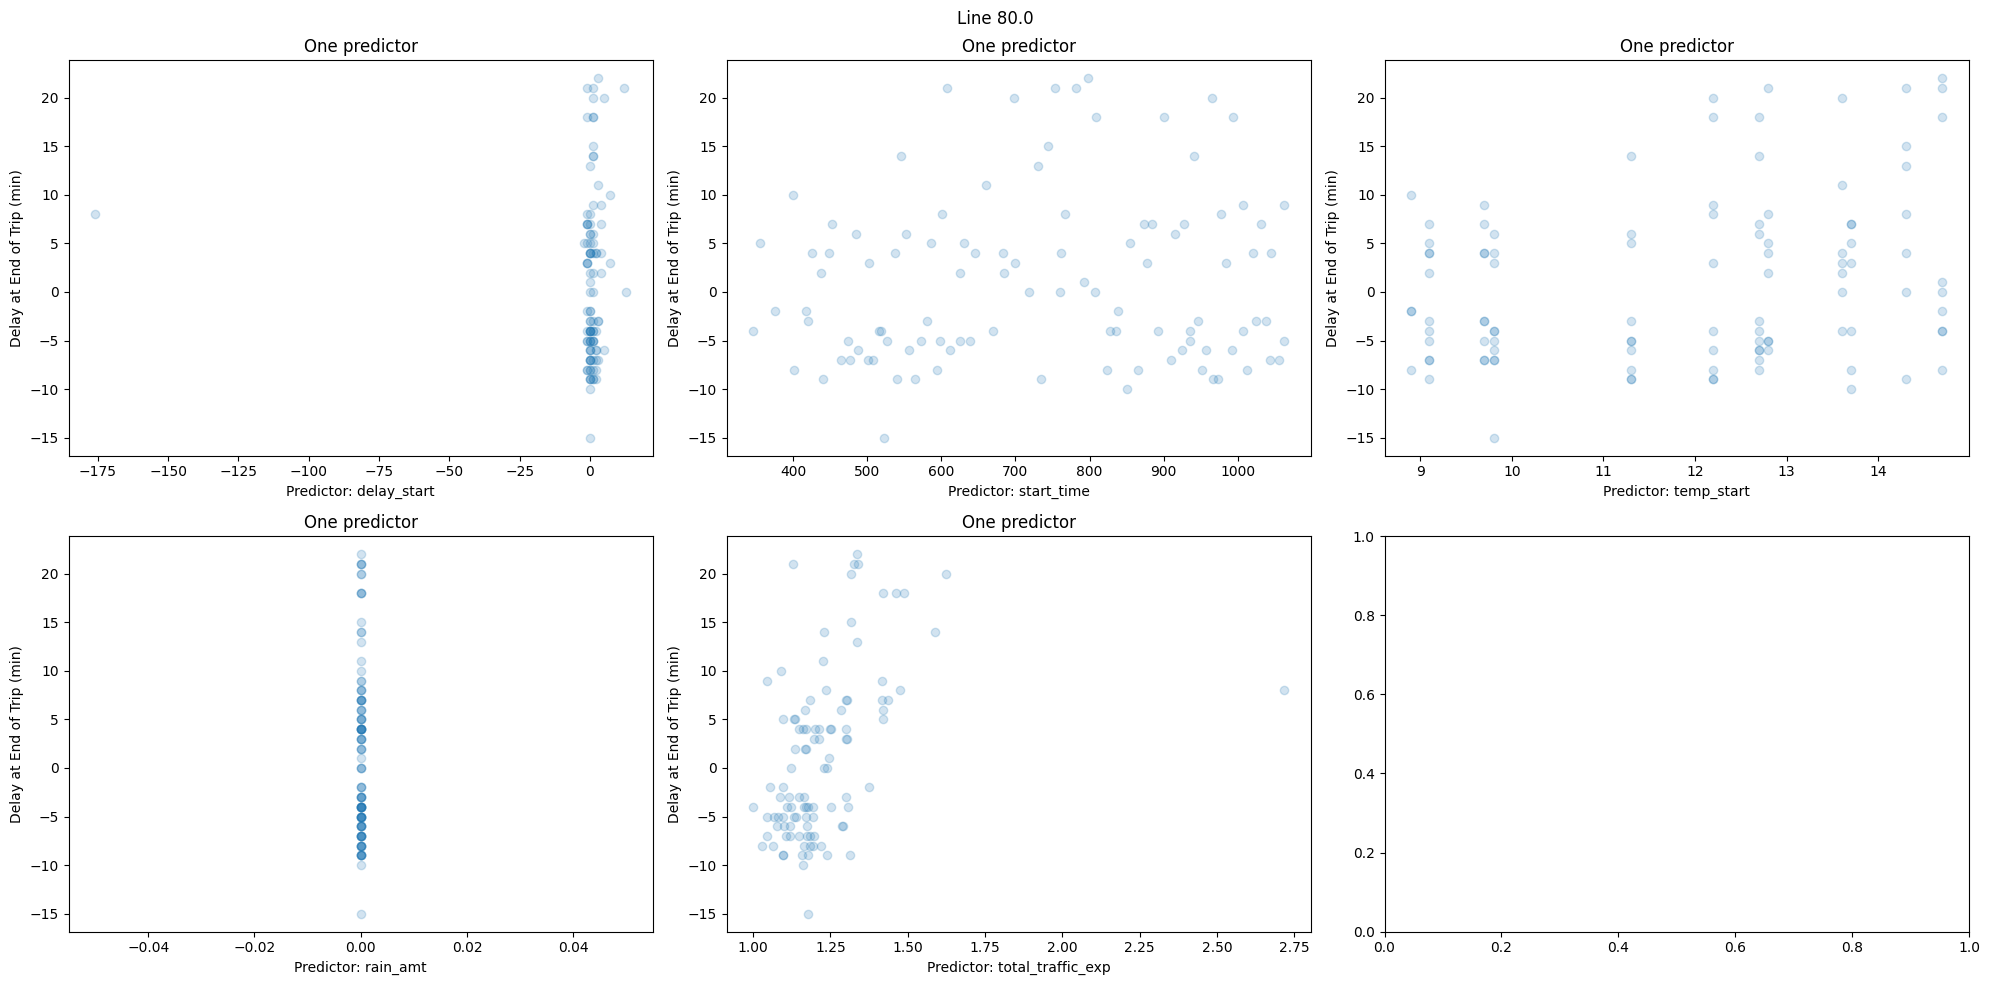

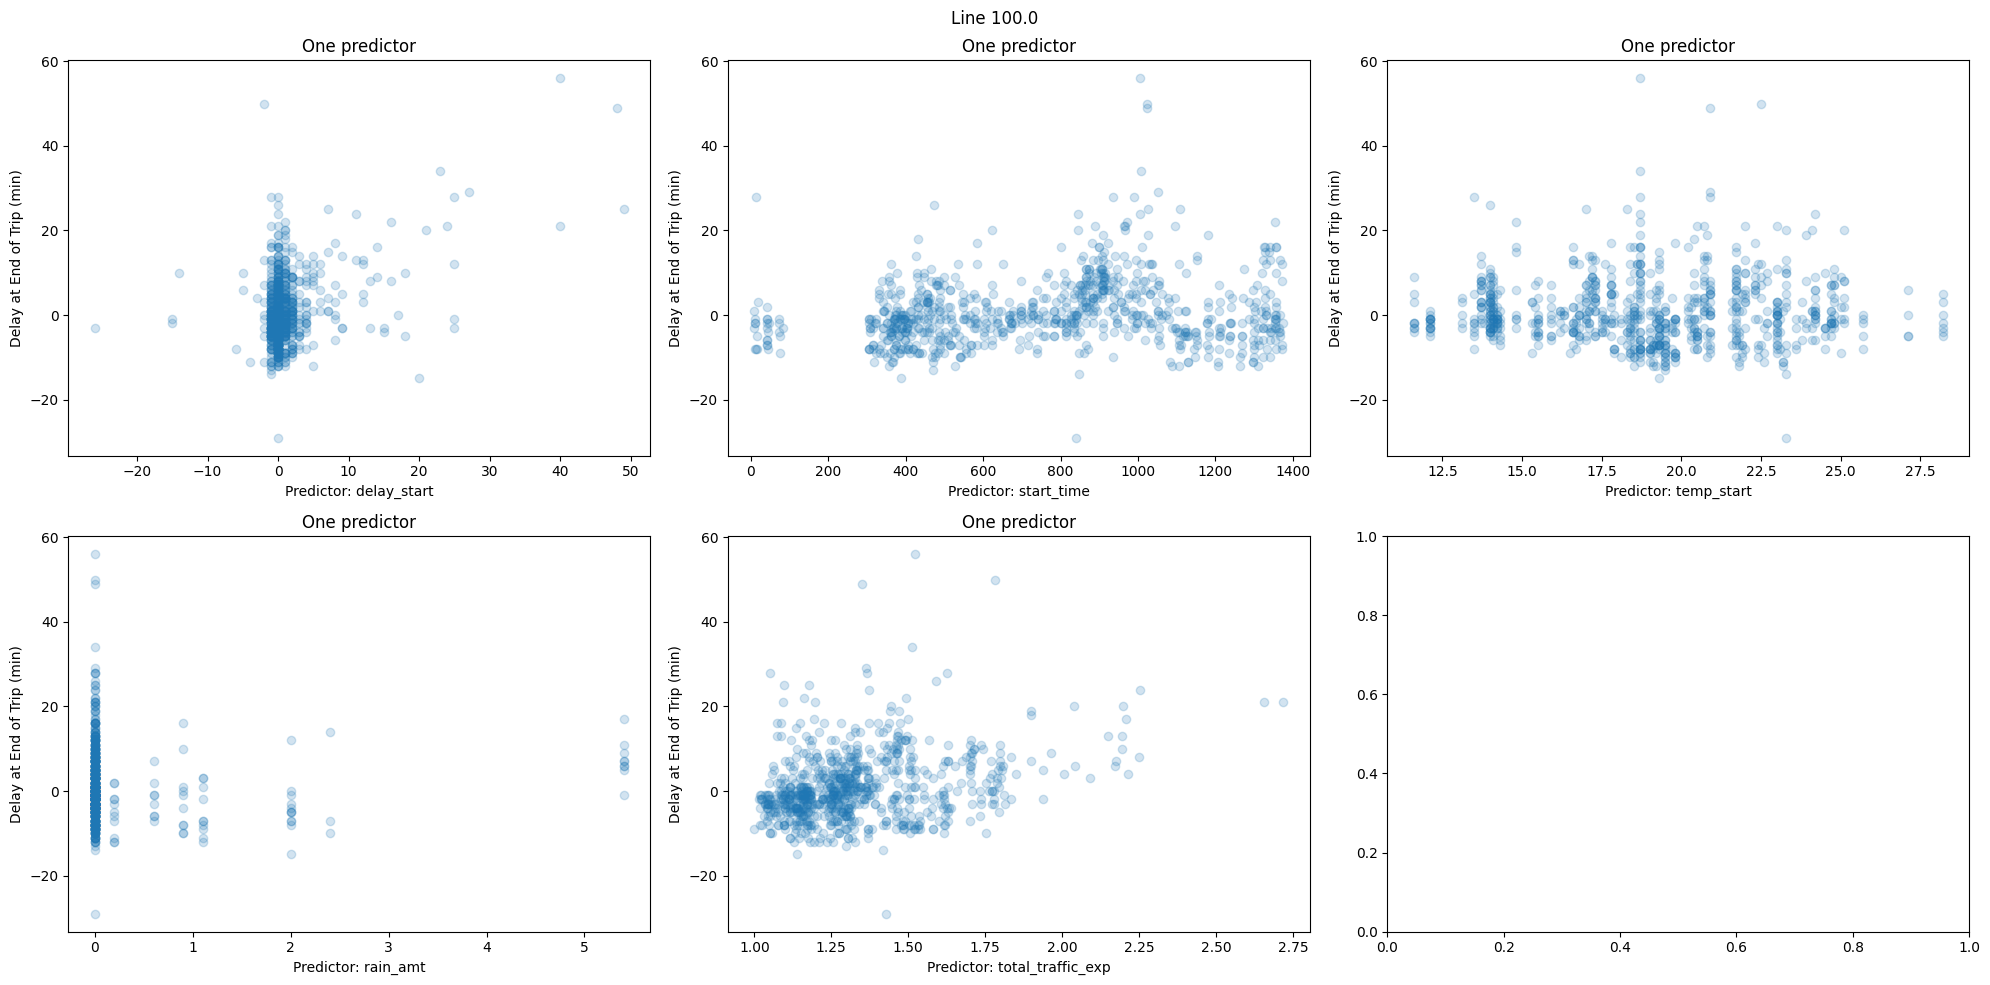

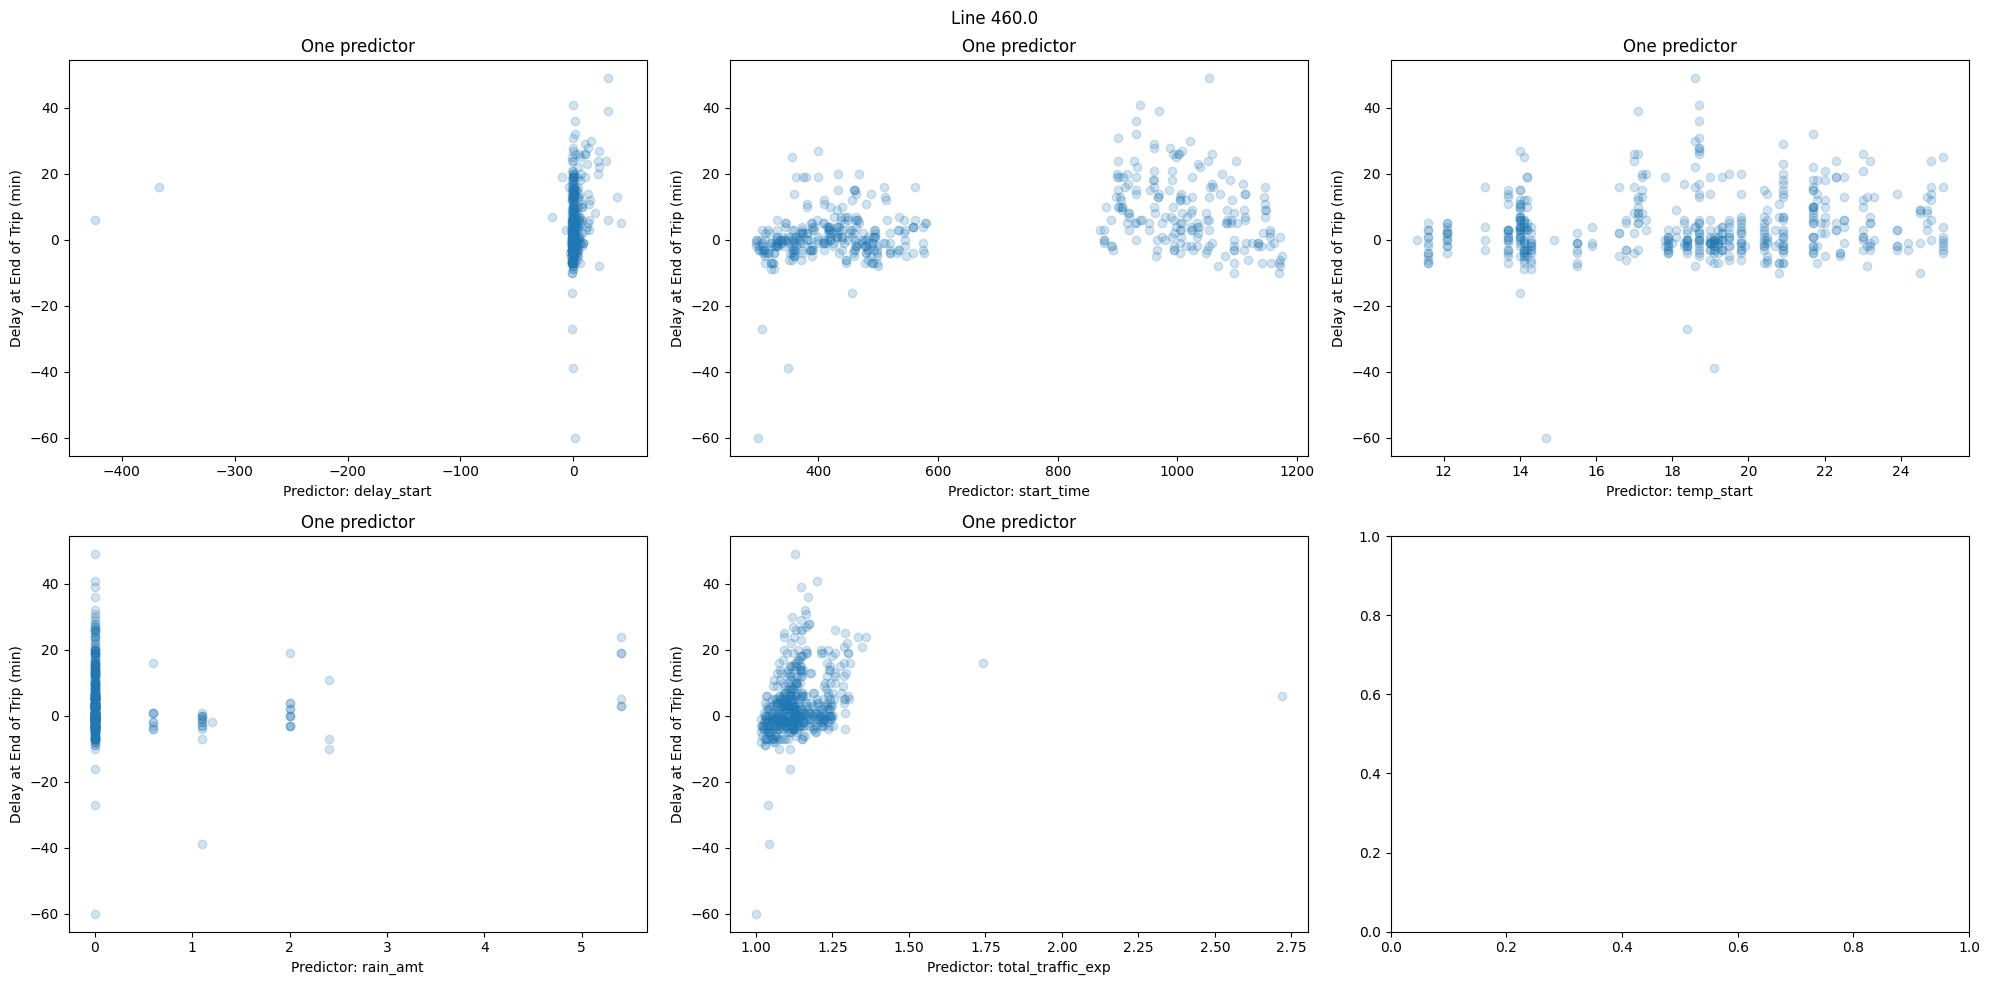

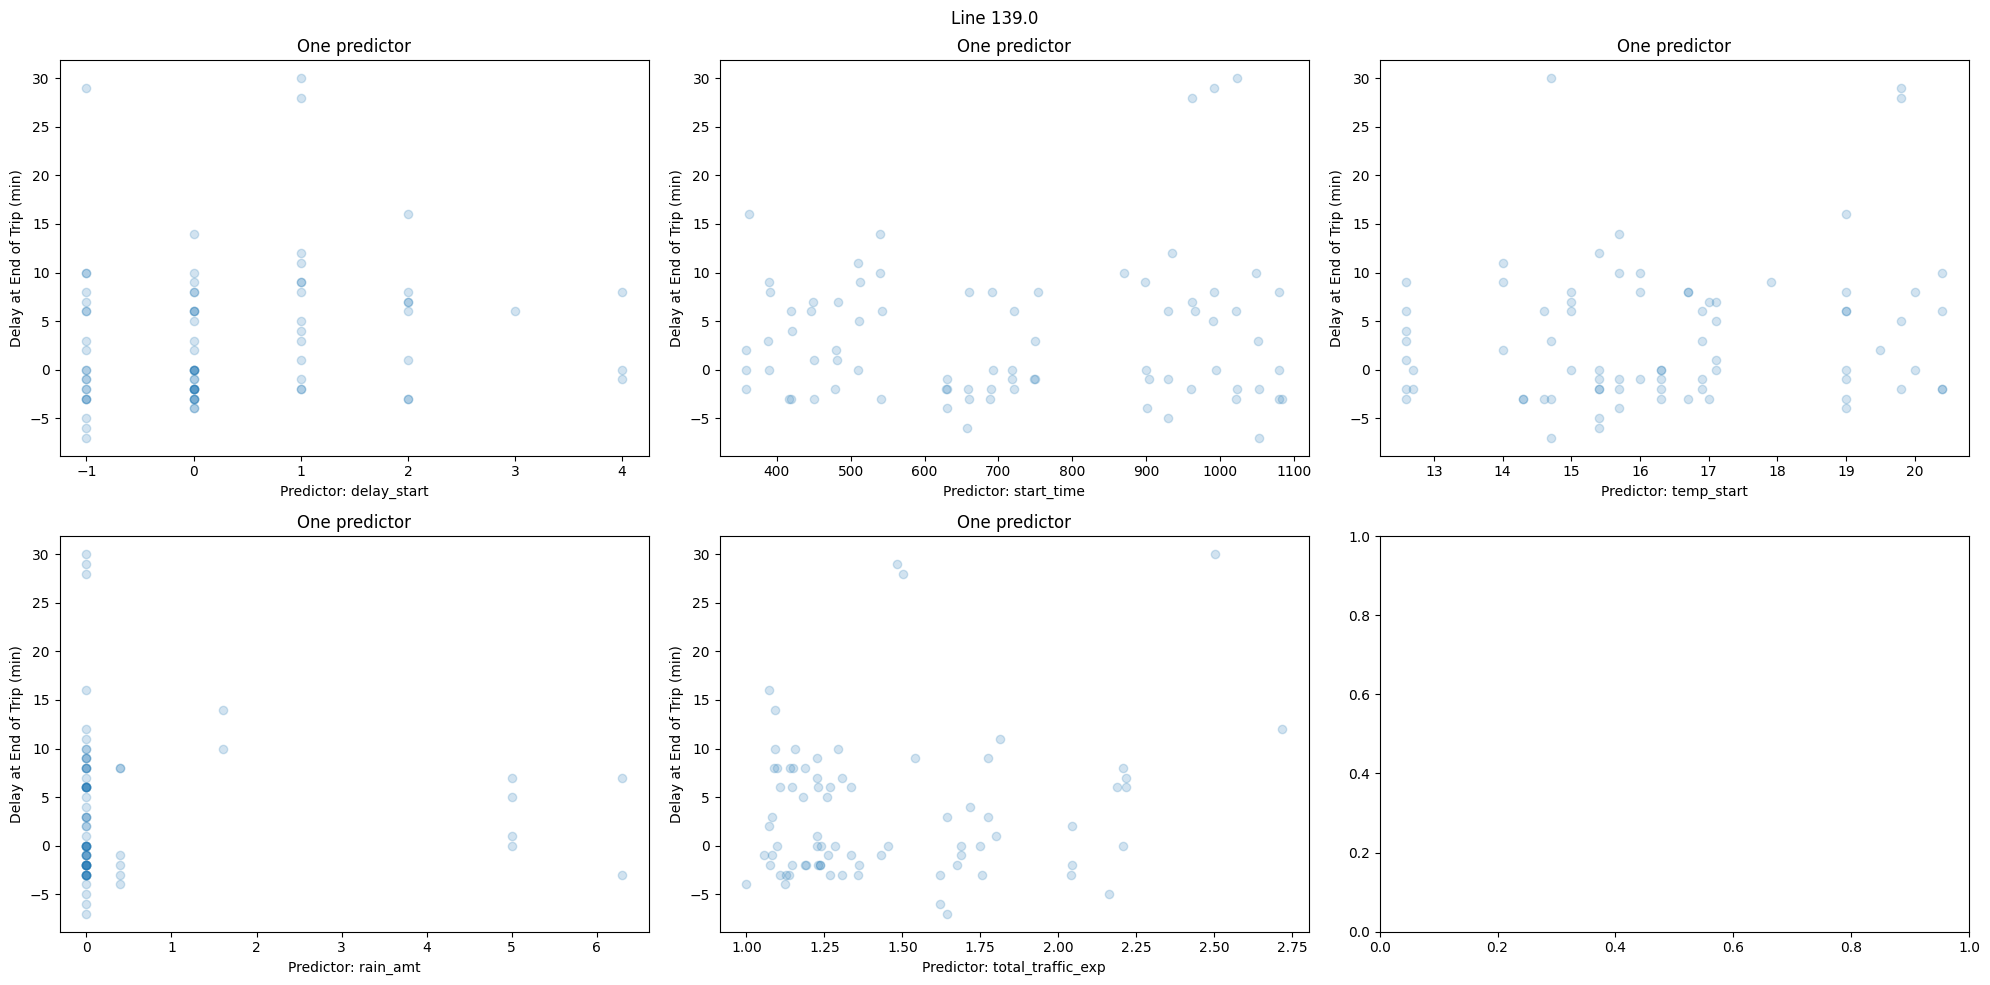

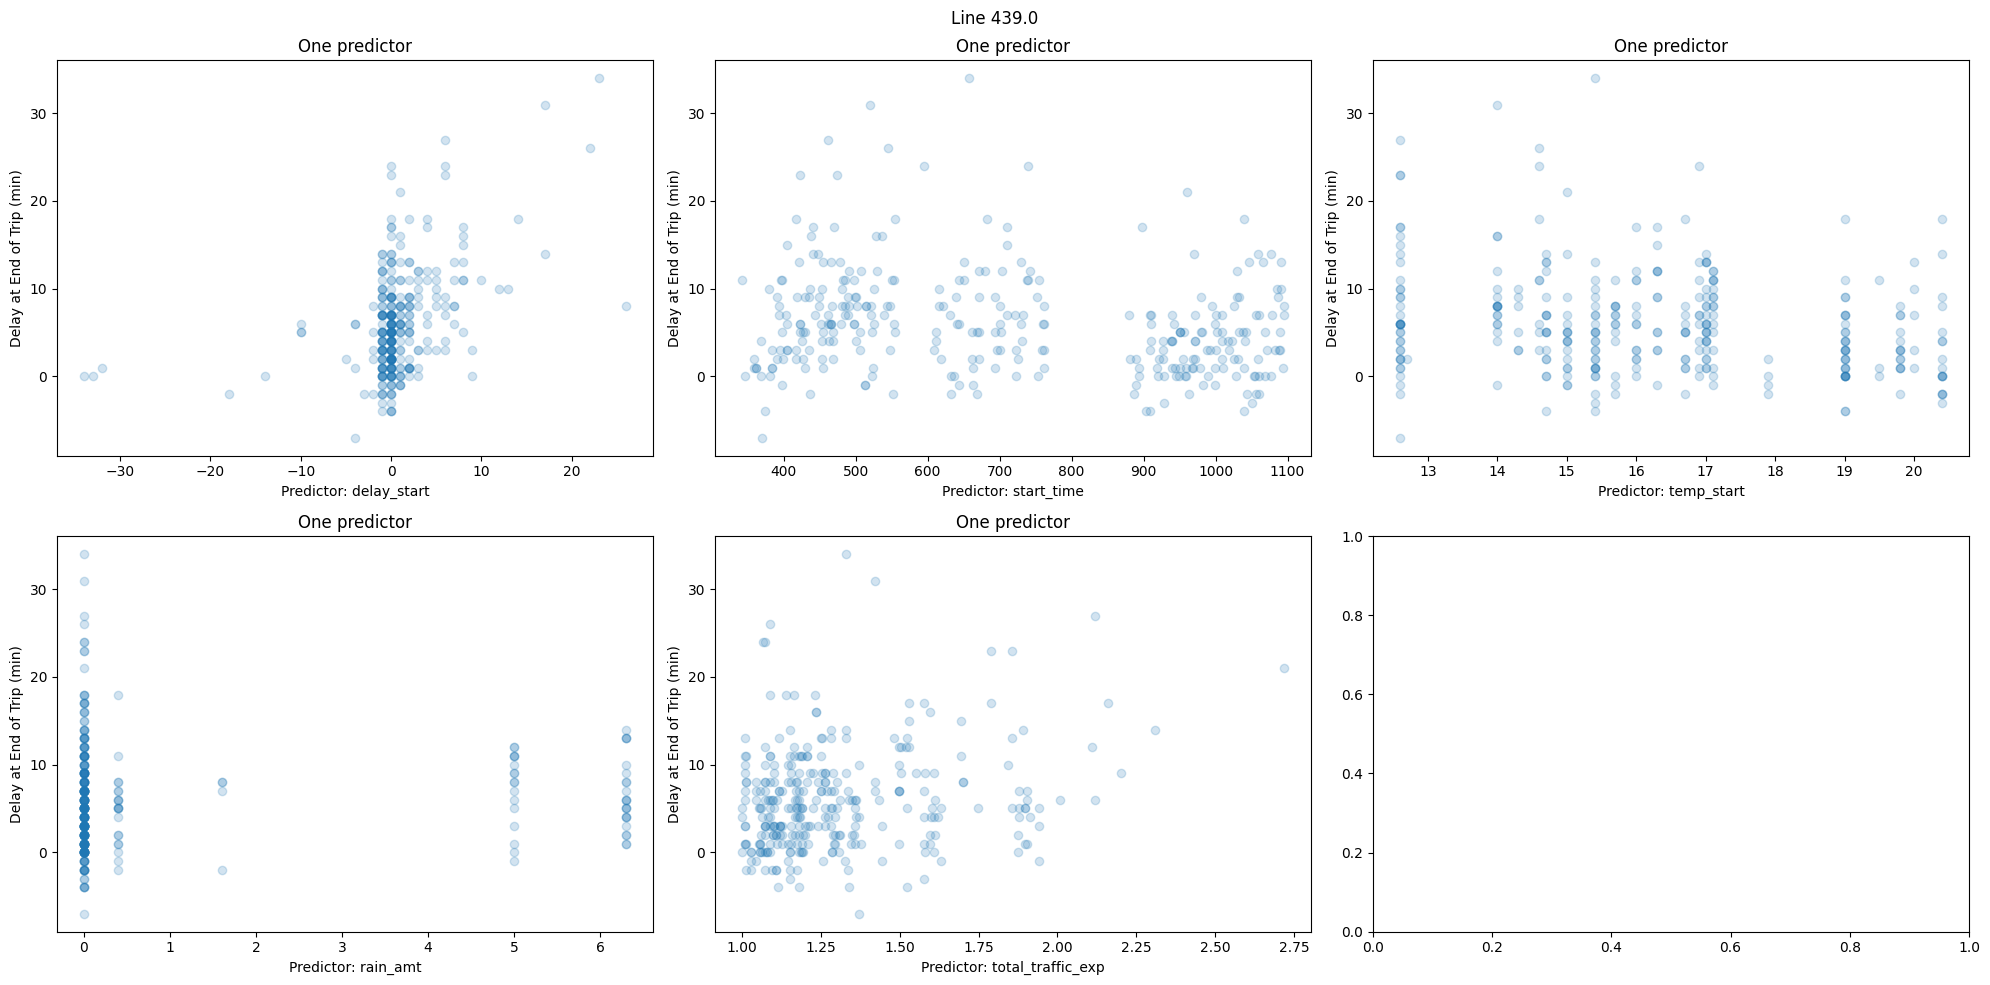

In [92]:
# Plot the outcome against the predictors for each line
# Store the plots as png files

for key in df_line_t.keys():
    fig, ax = plt.subplots(2, 3, figsize=(20, 10))
    for i, axi in enumerate(ax.flat):
        if i < len(predictors_lines_exp):
            axi.scatter(df_line_t[key][predictors_lines_exp[i]], df_line_t[key][outcome_lines_exp], color='tab:blue', alpha=0.2)
            axi.set_ylabel('Delay at End of Trip (min)')
            axi.set_xlabel(f'Predictor: {predictors_lines_exp[i]}')
            axi.set_title("One predictor")
    plt.suptitle(f'Line {key}')
    plt.tight_layout()
    plt.show()

In [93]:
# Find the number of datapoints in each line
keys = list(df_line_t.keys())
for key in keys:
    print(key, len(df_line_t[key]))

# Remove lines with less than 500 datapoints
keys = list(df_line_t.keys())
for key in keys:
    if len(df_line_t[key]) < 500:
        df_line_t.pop(key, None)


467.0 395
67.0 1218
480.0 171
121.0 1592
80.0 103
100.0 789
460.0 481
139.0 77
439.0 308


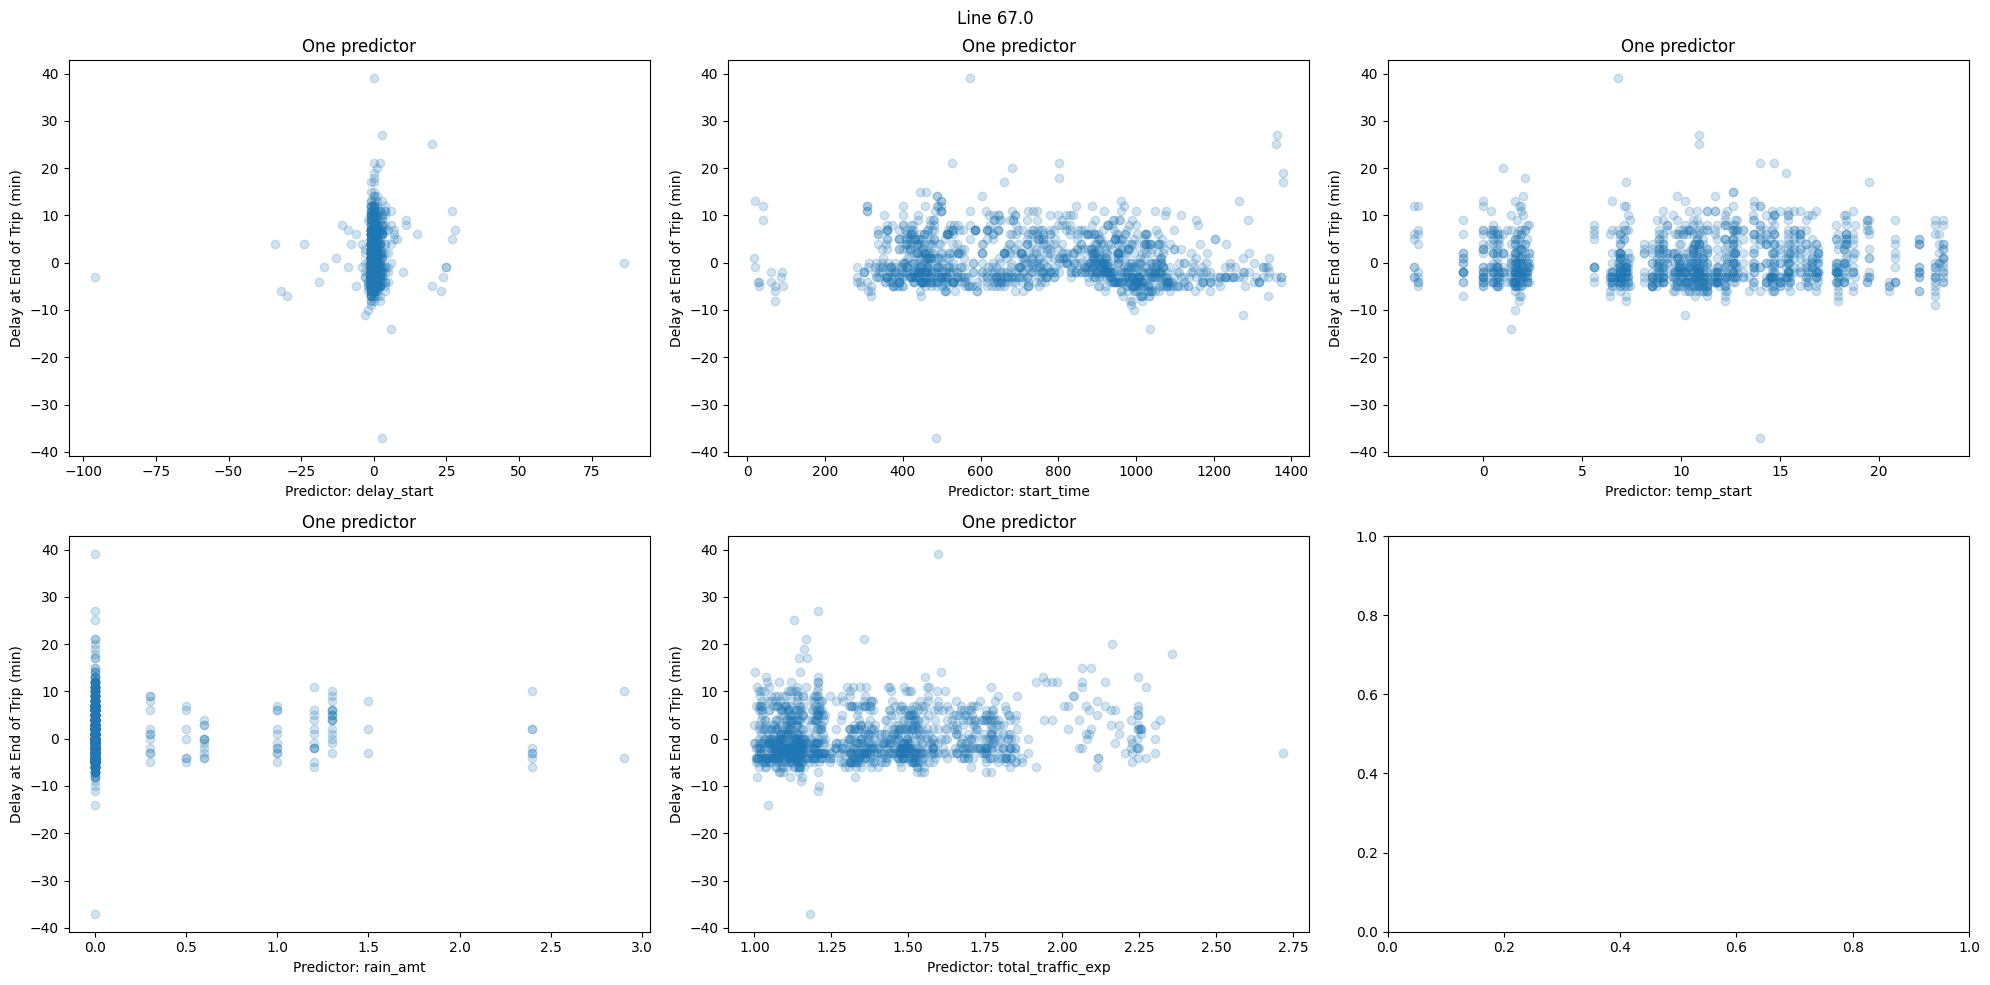

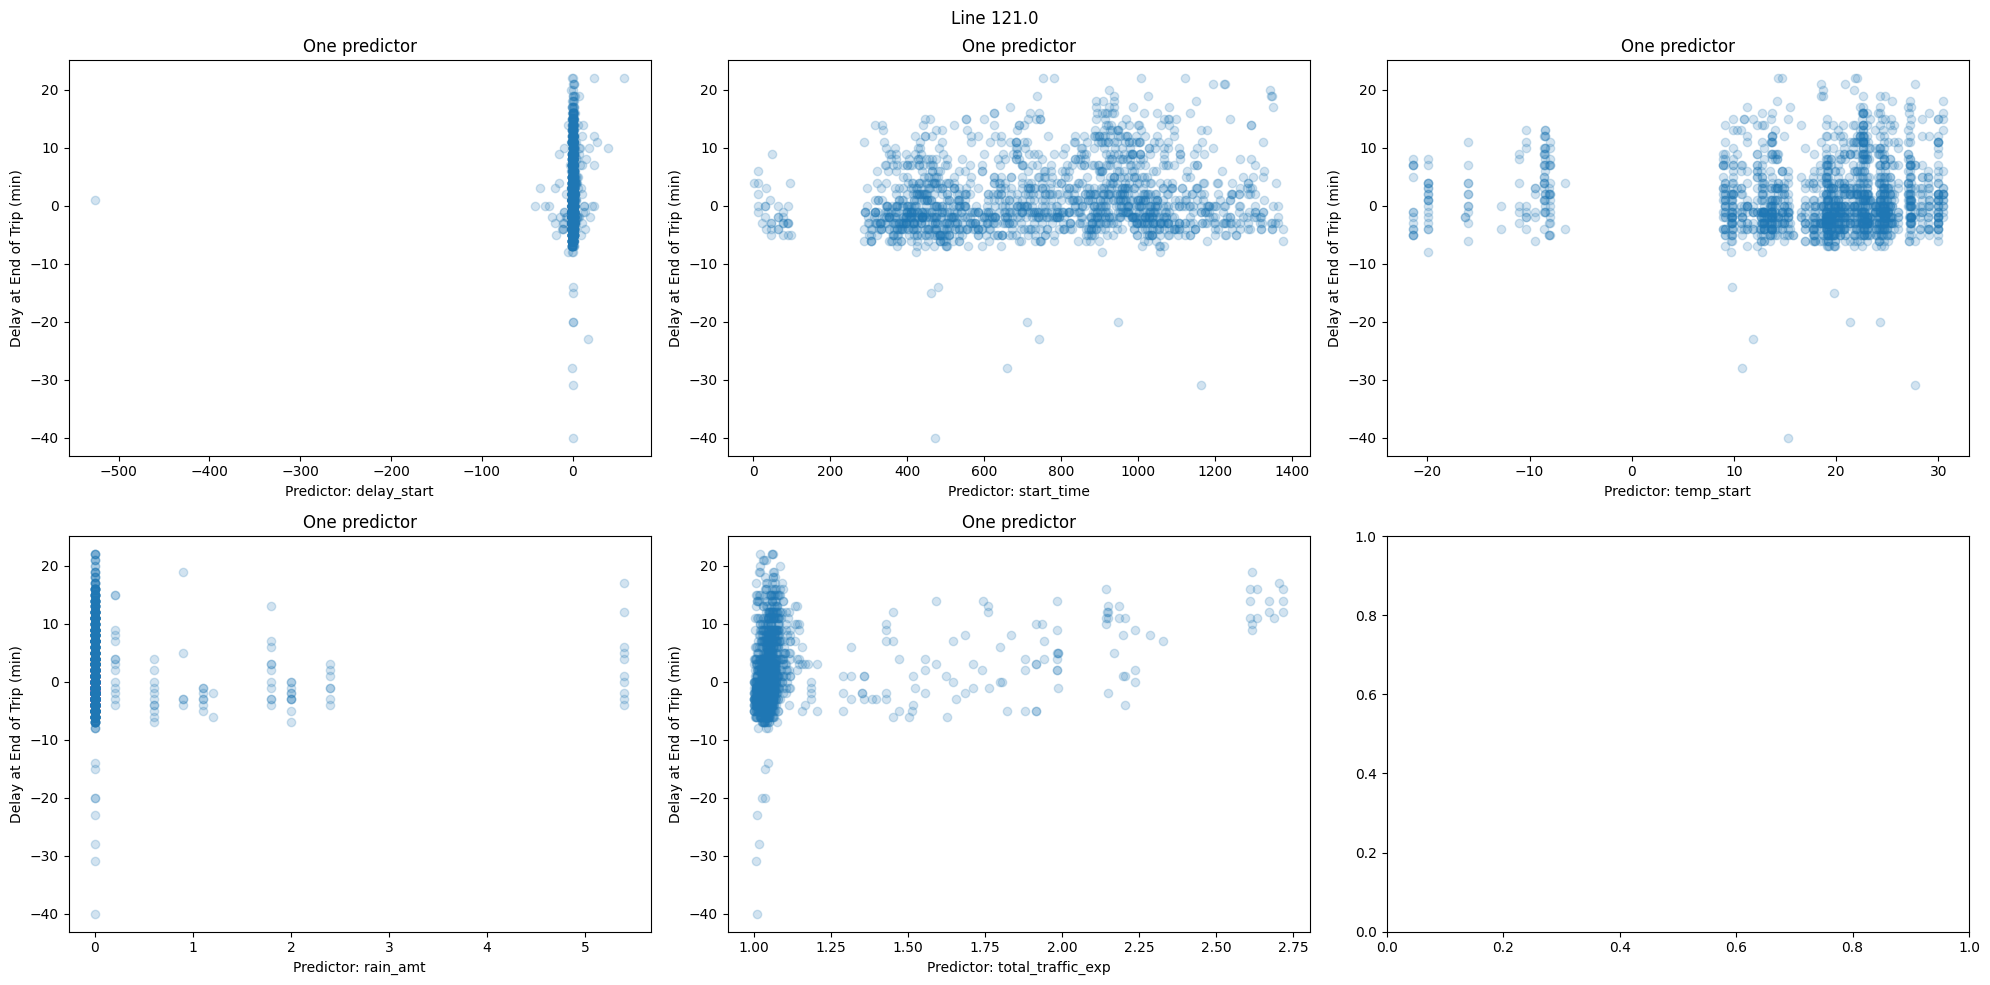

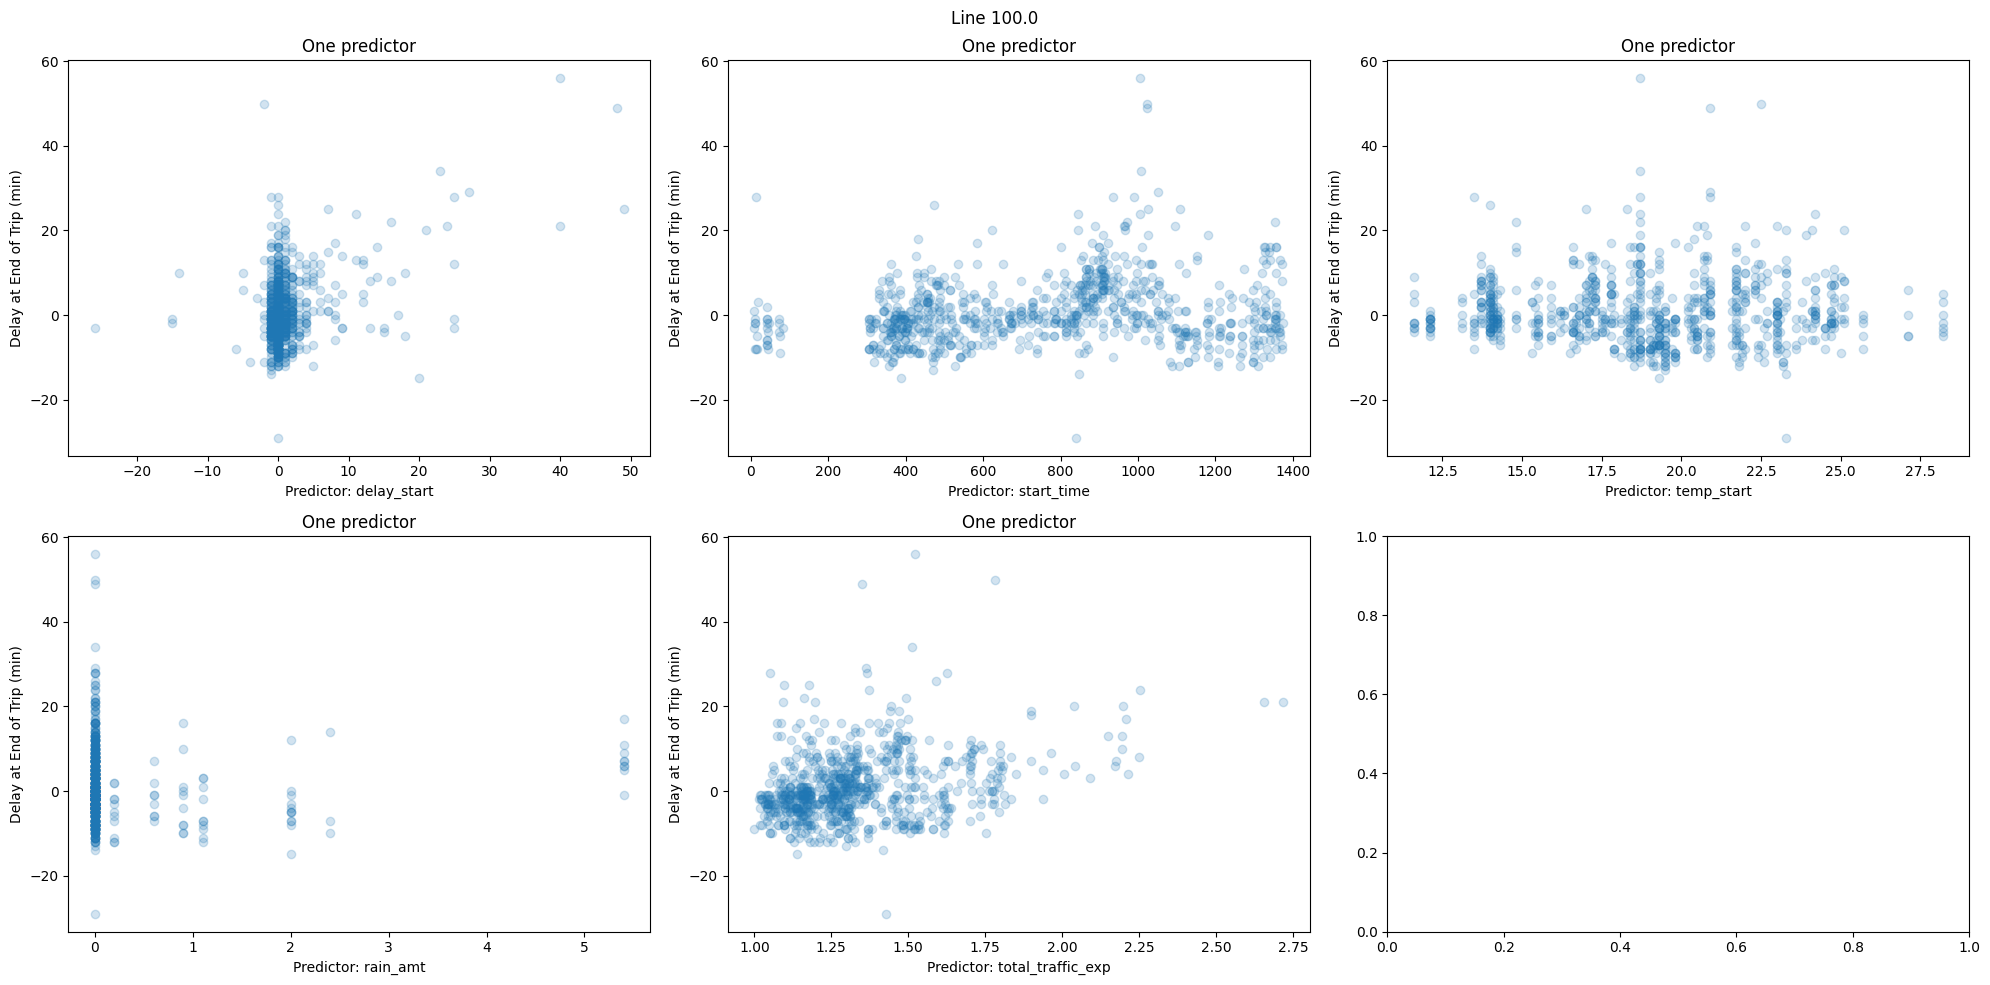

In [94]:
# Plot the outcome against the predictors for each line
# Store the plots as png files

for key in df_line_t.keys():
    fig, ax = plt.subplots(2, 3, figsize=(20, 10))
    for i, axi in enumerate(ax.flat):
        if i < len(predictors_lines_exp):
            axi.scatter(df_line_t[key][predictors_lines_exp[i]], df_line_t[key][outcome_lines_exp], color='tab:blue', alpha=0.2)
            axi.set_ylabel('Delay at End of Trip (min)')
            axi.set_xlabel(f'Predictor: {predictors_lines_exp[i]}')
            axi.set_title("One predictor")
    plt.suptitle(f'Line {key}')
    plt.tight_layout()
    plt.savefig(f'../Data/Plots/traffic_exp/Line {key} exp.png')
    plt.show()